# **0 - HELPERS**

## 0.1 - Libraries

*Import required libraries*

In [1]:
# don't cache libraries (especially project library)
%load_ext autoreload
%autoreload 2

In [2]:
# setup and environment
import warnings
import os
from   pathlib import Path

# data manipulation
import re
import numpy as np
import pandas as pd

# images
from PIL import Image

# plots
import seaborn as sns
import matplotlib.pyplot as plt

# notebooks
from IPython.display import display, HTML

# time series
import pmdarima                    as     pm
from prophet                       import Prophet
from prophet.plot                  import plot_cross_validation_metric
from prophet.diagnostics           import cross_validation, performance_metrics
from statsmodels.tsa.seasonal      import seasonal_decompose
from statsmodels.tsa.stattools     import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model   import ARIMA

# causal inference
import statsmodels.formula.api as smf

# machine learning
from sklearn.model_selection       import TimeSeriesSplit

# model tracking
import mlflow

/home/ds-gustavo-cunha/.pyenv/versions/omdena_sp_train/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## 0.2 - Setup

*Define basic configurations*

In [3]:
#####################
# pandas dataframes #
#####################

# set cientific notation for pandas
pd.set_option(
    "display.float_format", "{:,.3f}".format
)  # used in some places like SeriesFormatter
pd.set_option(
    "display.precision", 3
)  # for regular formatting as well as scientific notation
pd.set_option(
    "styler.format.precision", 3
)  # The precision for floats and complex numbers
# don't truncate columns
pd.set_option("display.max_colwidth", 100)  # None for unlimited
# display all columns
pd.set_option("display.max_columns", None)
# display up to 100 rows
pd.set_option("display.max_rows", 100)
# display dimensions
pd.set_option("display.show_dimensions", True)
# define decimals and thousand separation
pd.set_option("styler.format.decimal", ",")
pd.set_option("styler.format.thousands", ".")

####################
# matplotlib plots #
####################

# set default plt figure size
plt.rcParams["figure.figsize"] = [10, 5]
# figure suptitle
plt.rcParams["figure.titlesize"] = "large"
plt.rcParams["figure.titleweight"] = "bold"
# set default plt font size
plt.rcParams["font.size"] = 24
# font weight
# plt.rcParams["font.weight"] = "bold"
# title location
plt.rcParams["axes.titlelocation"] = "left"
# title size
plt.rcParams["axes.titlesize"] = "large"
# title wight
plt.rcParams["axes.titleweight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"
# spines
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
# axis labels
plt.rcParams["xaxis.labellocation"] = "left"
plt.rcParams["yaxis.labellocation"] = "top"
# figure layout
plt.rcParams["figure.autolayout"] = False
# save figures
plt.rcParams["savefig.dpi"] = 900
plt.rcParams["savefig.facecolor"] = "white"
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["savefig.format"] = "png"

# set fivethirtyeight pallete
plt.style.use("fivethirtyeight")

#####################
# jupyter notebooks #
#####################

# set cell size to be expanded
display(HTML("<style>.container { width:100% !important; }</style>"))

## 0.3 - Functions

*Define functions that will be used on the notebook*

In [4]:
def forecast_performance(forecast, actual):
    """
    Calculate forecasting performance given predicted values and real values.
    Calculated metrics are: MAPE, MPE, MAE, RMSE, RMSLE.

    Args
        forcast: a array-like object with predictions.
        actual: a array-like object with real values.

    Return
        a dict with keys as calculated metrics and values as their respective values
    """

    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
    mpe = np.mean((forecast - actual)/actual)
    mae = np.mean(np.abs(forecast - actual))
    rmse = np.sqrt( np.mean( (forecast - actual)**2 ) )
    rmsle = np.sqrt( np.mean( ( np.log1p(forecast) / np.log1p(actual) )**2 ) )

    return {"mape":mape, "mpe":mpe, "mae": mae, 
            "rmse":rmse, "rmsle":rmsle}

## 0.4 - Constants

*Define reusuable constants*

In [5]:
# define the project root path that will be the "baseline" for all paths in the notebook
PROJECT_ROOT_PATH = Path.cwd().parent.parent.parent.parent
PROJECT_ROOT_PATH

PosixPath('/home/ds-gustavo-cunha/Projects/omdena_sp_train')

In [6]:
# define war data folder path
RAW_DATA_PATH = os.path.join(PROJECT_ROOT_PATH, "src", "tasks", "task_1_data_collection_preprocessing", "final_datasets")

# inspect folder
os.listdir(RAW_DATA_PATH)

['l01_pes_complete.csv',
 'README.md',
 'l05_pel_complete.csv',
 'alllines_pes_complete_reshaped.csv',
 'publiclines_pel_complete.csv',
 'alllines_pes_complete.csv',
 'publiclines_ibt_complete.csv',
 'publiclines_pel_21.csv',
 'l15_pes_complete.csv',
 'l04_pel_complete.csv',
 'alllines_ptl_complete.csv',
 'l02_pes_complete.csv',
 'publiclines_pel_22.csv',
 'l04_pes_complete.csv',
 'l03_pes_complete.csv',
 'publiclines_pel_21-23.csv',
 'l05_pes_complete.csv']

# **1 - DATA EXTRACTION**

## 1.1 - Entity Relationship Diagram

*Display Entity-Relationship Diagram to a better data understanding*

In [7]:
# To-DO

## 1.2 - Data Fields Description

*Describe available data in regard to database information*


#### **This folder contains the final datasets that should be used by the other teams**

- Check our Notion for the Feature's Schema. Does your dataset follow the schema?
- Follow this pattern for the file name: line_dataset_year where:
1. line = l + line number, with 2 digits. Check Notion for line's number. Ex.: l01
2. dataset: Where the data came from? Passengers transported by line = ptl, Passengers entry by line = pel, Passengers entry by station = pes. Ex.: l01_pel
3. year: Year with 2 digits. If the dataset is for the hole time span (2017-2023), use complete. Ex.: l1_pel_23 OR l3_pes_complete

#### **Github structure**

- Check for the folder **final_datasets**. This is the place for the final files.
- Follow this pattern for the file name: line_dataset_year where:
    1. line = l + line number, with 2 digits. If the dataset contains all the public lines or all the private lines, you should use: publiclines OR privatelines OR alllines (public + private)
        
        Ex.: **l01 or publiclines**
        
    2. dataset: Where the data came from? 
        1. Passengers transported by line = ptl,
        2. Passengers entry by line = pel,
        3. Passengers entry by station = pes. 
        
        Ex.: **l01_pel or publiclines_pel**
        
    3. year: Year with 2 digits. If the dataset is for the hole time span (2017-2023), use complete.
        
        Ex.: **l1_pel_23 OR l3_pes_complete OR publiclines_pes_complete**
        
    4. Exemples:
        - The dataset **l04_pel_22.csv** contains data for Yellow line, with Passengers entry by line for 2022
        - The dataset **publiclines_pes_complete** contains data for all the public lines (1,2,3 and 15), with passengers entry by line for all the years

#### Features - Schema

**Passenger entrance by line datasets**

- date - Month when the data was collected - datetime (yyyy-mm-dd)
- line - Subway line number - int
- total - Total of passengers that entered the station on that month - int
- business_day_mean - (MDU) Mean of passengers that entered the station on that month on business day - int
- saturday_mean - (MSA) Mean of passengers that entered the station on that month on saturdays - int
- sunday_mean - (MD0) Mean of passengers that entered the station on that month on sundays - int
- max - (MAX) Maximum of passengers entered on one day on that month - int

**Daily average passenger entrance by station on business days datasets**

- date - Month when the data was collected - datetime (yyyy-mm-dd)
- line - Subway line number - int
- station - Subway station - categorical?
- dpea - Daily average passenger entrance by station - int

**Passengers transported by line datasets**

- date - Month when the data was collected - datetime (yyyy-mm-dd)
- line - Subway line number - int
- total - Total of passengers transported by line on that month - int
- business_day_mean - (MDU) Mean of passengers transported on that month on business day - int
- saturday_mean - (MSA) Mean of passengers transported on that month on saturdays - int
- sunday_mean - (MD0) Mean of passengers transported on that month on sundays - int
- max - (MAX) Maximum of passengers transported on one day on that month - int

## 1.3 - Data Loading

*Load data from required files*

In [8]:
# define file to load data
FILE = os.path.join(RAW_DATA_PATH, "alllines_ptl_complete.csv")

# read data from csv
df_extraction = pd.read_csv(
    filepath_or_buffer=FILE,
    parse_dates=["year_month"],
    infer_datetime_format=True
    #date_format="%Y-%m-%d"
    )

# inspect loaded dataset
display(
    df_extraction.dtypes,
    df_extraction
    )

/tmp/ipykernel_22277/3699064788.py:5: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_extraction = pd.read_csv(


year_month                  datetime64[ns]
line                                 int64
total                              float64
MDU (Business Days Mean)           float64
MSD (Saturdays Mean)               float64
MDO (Sundays Mean)                 float64
MAX (Daily Max)                    float64
Length: 7, dtype: object

,year_month,line,total,MDU (Business Days Mean),MSD (Saturdays Mean),MDO (Sundays Mean),MAX (Daily Max)
0,2018-08-01,3,"38,679,000.000","1,440,000.000","884,000.000","504,000.000","1,483,000.000"
1,2018-08-01,1,"37,775,000.000","1,420,000.000","832,000.000","446,000.000","1,466,000.000"
2,2018-08-01,15,"516,000.000","22,000.000",NaN,"2,000.000","23,000.000"
3,2018-08-01,2,"18,164,000.000","701,000.000","318,000.000","194,000.000","723,000.000"
4,2018-08-01,5,"7,220,000.000","309,000.000","176,000.000","85,000.000","322,000.000"
...,...,...,...,...,...,...,...
337,2023-04-01,2,"14,544,000.000","649,000.000","299,000.000","189,000.000","671,000.000"
338,2023-04-01,4,"15,070,570.000","661,450.000","338,300.000","201,580.000","701,710.000"
339,2023-04-01,5,"11,792,220.000","510,810.000","282,420.000","160,710.000","527,250.000"
340,2023-04-01,1,"25,545,000.000","1,091,000.000","639,000.000","375,000.000","1,130,000.000"


# **2 - DATA DESCRIPTION**

## 2.1 - Restore Point

*Create a checkpoint of the last dataframe from previous section*

In [9]:
# create a restore point of the previous section
df_description = df_extraction.copy()

## 2.2 - Rename Columns

*Search for misleading or error-prone column names*

In [10]:
# check column names
df_description.columns

Index(['year_month', 'line', 'total', 'MDU (Business Days Mean)',
       'MSD (Saturdays Mean)', 'MDO (Sundays Mean)', 'MAX (Daily Max)'],
      dtype='object')

In [11]:
# rename columns to avoid spaces
df_description = df_description.rename(columns={
    "MDU (Business Days Mean)":"mdu_business_days_mean",
    "MSD (Saturdays Mean)": "msd_saturdays_mean",
    "MDO (Sundays Mean)": "mdo_sundays_Mean",
    "MAX (Daily Max)": "max_daily_max"
})

# check column names
df_description.columns

Index(['year_month', 'line', 'total', 'mdu_business_days_mean',
       'msd_saturdays_mean', 'mdo_sundays_Mean', 'max_daily_max'],
      dtype='object')

## 2.3 - Check Data Dimensions

*Check dataframe dimensions to know if pandas will be enough to handle such data size or we will need Big Data tools like Spark*

In [12]:
# check number of rows and columns
print( f'\
Dataframe has {df_description.shape[0]:,} \
rows and {df_description.shape[1]} columns' )

Dataframe has 342 rows and 7 columns


## 2.4 - Data Types

*Check if data types on dataframe makes sense according to database information*

In [13]:
# inspect dataframe types
display(
    df_description.dtypes,
    df_description.head(3)
    )

year_month                datetime64[ns]
line                               int64
total                            float64
mdu_business_days_mean           float64
msd_saturdays_mean               float64
mdo_sundays_Mean                 float64
max_daily_max                    float64
Length: 7, dtype: object

,year_month,line,total,mdu_business_days_mean,msd_saturdays_mean,mdo_sundays_Mean,max_daily_max
0,2018-08-01,3,"38,679,000.000","1,440,000.000","884,000.000","504,000.000","1,483,000.000"
1,2018-08-01,1,"37,775,000.000","1,420,000.000","832,000.000","446,000.000","1,466,000.000"
2,2018-08-01,15,"516,000.000","22,000.000",NaN,"2,000.000","23,000.000"


## 2.6 - Check Duplicated Rows

*Inspect duplicated rows and handle them properly*

In [14]:
# define dataframe granularity
df_grain = ["year_month","line"]

# check duplicated rows
print(
    f'{"*"*49}\n\n'
    f'There are {df_description.duplicated(keep=False).sum():,} \
duplicated rows [{df_description.duplicated(keep=False).mean()*100:.2f}%] based on all columns. \
Duplicated rows are double counted.'
    f'\n\n{"*"*49}\n\n'
    f'There are {df_description.duplicated(subset=df_grain, keep=False).sum():,} duplicated rows [{df_description.duplicated(subset=df_grain, keep=False).mean()*100:.2f}%] based on table granularity. \
Duplicated rows are double counted.'
    f'\n\n{"*"*49}'
)

*************************************************

There are 0 duplicated rows [0.00%] based on all columns. Duplicated rows are double counted.

*************************************************

There are 0 duplicated rows [0.00%] based on table granularity. Duplicated rows are double counted.

*************************************************


## 2.7 - Check Missing Values

*Inspect number and percentage of missing value per column to decide what to do with them*

In [15]:
#  get number of NAs
display(
    "Total of NAs",
    df_description.isna().sum(),
    "Percent of NAs",
    df_description.isna().mean()
)

'Total of NAs'

year_month                0
line                      0
total                     3
mdu_business_days_mean    3
msd_saturdays_mean        5
mdo_sundays_Mean          3
max_daily_max             3
Length: 7, dtype: int64

'Percent of NAs'

year_month               0.000
line                     0.000
total                    0.009
mdu_business_days_mean   0.009
msd_saturdays_mean       0.015
mdo_sundays_Mean         0.009
max_daily_max            0.009
Length: 7, dtype: float64

In [16]:
# inspect rows with NAs
df_description[df_description.isna().any(axis=1)]

,year_month,line,total,mdu_business_days_mean,msd_saturdays_mean,mdo_sundays_Mean,max_daily_max
2,2018-08-01,15,"516,000.000","22,000.000",NaN,"2,000.000","23,000.000"
16,2018-10-01,15,"498,000.000","22,000.000",NaN,"4,000.000","25,000.000"
114,2020-03-01,15,NaN,NaN,NaN,NaN,NaN
122,2020-04-01,15,NaN,NaN,NaN,NaN,NaN
131,2020-05-01,15,NaN,NaN,NaN,NaN,NaN


## 2.8 - Handle Missing Values

*Handle missing value for columns*

In [17]:
# No NA will be handled for this first iteration

## 2.9 - Descriptive Statistics

*Inspect some summary statistics for numerical columns*

In [18]:
# To-Do

### 2.9.4 - Investigate further:

*Variables to inspect the real meaning*

In [19]:
# ###################
# !!!!!!! NAs !!!!!!!
# ###################

# **3 - FEATURE ENGINEERING**

## 3.1 - Restore Point

*Create a checkpoint of the last dataframe from previous section*

In [20]:
# create a restore point for the previous section dataframe
df_f_eng = df_description.copy()

# display
df_f_eng

,year_month,line,total,mdu_business_days_mean,msd_saturdays_mean,mdo_sundays_Mean,max_daily_max
0,2018-08-01,3,"38,679,000.000","1,440,000.000","884,000.000","504,000.000","1,483,000.000"
1,2018-08-01,1,"37,775,000.000","1,420,000.000","832,000.000","446,000.000","1,466,000.000"
2,2018-08-01,15,"516,000.000","22,000.000",NaN,"2,000.000","23,000.000"
3,2018-08-01,2,"18,164,000.000","701,000.000","318,000.000","194,000.000","723,000.000"
4,2018-08-01,5,"7,220,000.000","309,000.000","176,000.000","85,000.000","322,000.000"
...,...,...,...,...,...,...,...
337,2023-04-01,2,"14,544,000.000","649,000.000","299,000.000","189,000.000","671,000.000"
338,2023-04-01,4,"15,070,570.000","661,450.000","338,300.000","201,580.000","701,710.000"
339,2023-04-01,5,"11,792,220.000","510,810.000","282,420.000","160,710.000","527,250.000"
340,2023-04-01,1,"25,545,000.000","1,091,000.000","639,000.000","375,000.000","1,130,000.000"


## 3.2 - Hypothesis Testing List

*Define the list of hypotheses that will be validated during Exploratory Data Analysis (EDA)*

H1. **...**

H2. **...**

H3. **...**

H4. **...**

H5. **...**

## 3.3 - Feature Creation

*Create new features (columns) that can be meaningful for EDA and, especially, machine learning modelling.*

In [21]:
# No variable will be created for this first iteration

# **4 - DATA FILTERING**

## 4.1 - Restore Point

*Create a checkpoint of the last dataframe from previous section*

In [22]:
# create a restore point for the previous section dataframe
df_filter = df_f_eng.copy()

# check dataframe
df_filter

,year_month,line,total,mdu_business_days_mean,msd_saturdays_mean,mdo_sundays_Mean,max_daily_max
0,2018-08-01,3,"38,679,000.000","1,440,000.000","884,000.000","504,000.000","1,483,000.000"
1,2018-08-01,1,"37,775,000.000","1,420,000.000","832,000.000","446,000.000","1,466,000.000"
2,2018-08-01,15,"516,000.000","22,000.000",NaN,"2,000.000","23,000.000"
3,2018-08-01,2,"18,164,000.000","701,000.000","318,000.000","194,000.000","723,000.000"
4,2018-08-01,5,"7,220,000.000","309,000.000","176,000.000","85,000.000","322,000.000"
...,...,...,...,...,...,...,...
337,2023-04-01,2,"14,544,000.000","649,000.000","299,000.000","189,000.000","671,000.000"
338,2023-04-01,4,"15,070,570.000","661,450.000","338,300.000","201,580.000","701,710.000"
339,2023-04-01,5,"11,792,220.000","510,810.000","282,420.000","160,710.000","527,250.000"
340,2023-04-01,1,"25,545,000.000","1,091,000.000","639,000.000","375,000.000","1,130,000.000"


## 4.2 Rows Filtering

*Remove rows with meaningless (or unimportant) data*

In [23]:
# No row will be removed for this first iteration

## 4.3 - Columns Filtering

*Remove auxiliary columns or columns that won't be available in the prediction moment*

In [24]:
# No row will be removed for this first iteration

# **5 - EXPLORATORY DATA ANALYSIS**

## 5.1 - Restore Point

*Create a checkpoint of the last dataframe from previous section*

In [25]:
# create a restore point for the previous section dataframe
df_eda = df_filter.copy()

# check dataframe
df_eda

,year_month,line,total,mdu_business_days_mean,msd_saturdays_mean,mdo_sundays_Mean,max_daily_max
0,2018-08-01,3,"38,679,000.000","1,440,000.000","884,000.000","504,000.000","1,483,000.000"
1,2018-08-01,1,"37,775,000.000","1,420,000.000","832,000.000","446,000.000","1,466,000.000"
2,2018-08-01,15,"516,000.000","22,000.000",NaN,"2,000.000","23,000.000"
3,2018-08-01,2,"18,164,000.000","701,000.000","318,000.000","194,000.000","723,000.000"
4,2018-08-01,5,"7,220,000.000","309,000.000","176,000.000","85,000.000","322,000.000"
...,...,...,...,...,...,...,...
337,2023-04-01,2,"14,544,000.000","649,000.000","299,000.000","189,000.000","671,000.000"
338,2023-04-01,4,"15,070,570.000","661,450.000","338,300.000","201,580.000","701,710.000"
339,2023-04-01,5,"11,792,220.000","510,810.000","282,420.000","160,710.000","527,250.000"
340,2023-04-01,1,"25,545,000.000","1,091,000.000","639,000.000","375,000.000","1,130,000.000"


## 5.2 - Univariate Analysis

*Explore variables distributions*

In [26]:
# split dataset into types of features
df_eda_num = df_eda.select_dtypes(include=["number", "bool"])
df_eda_date = df_eda.select_dtypes(include=["datetime"])
df_eda_str = df_eda.select_dtypes(include=["object"])

# sanity check
assert df_eda_num.shape[1] + df_eda_date.shape[1] + df_eda_str.shape[1] == df_eda.shape[1], """Revise the previous split, something may be wrong!"""

### 5.2.1 - Numerical Columns

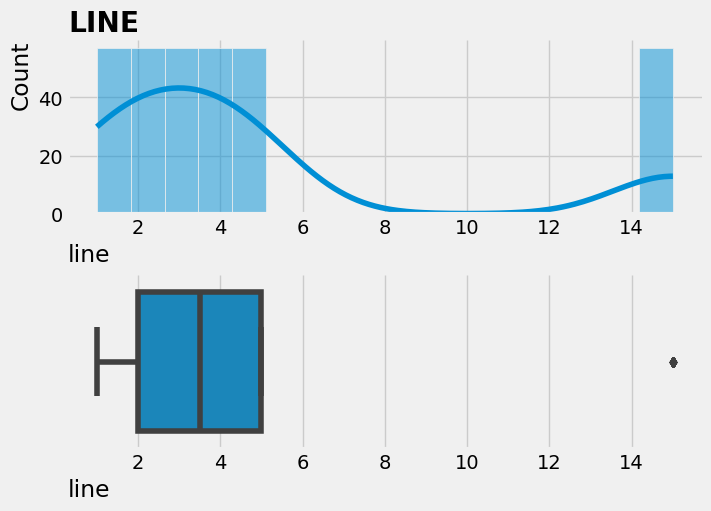

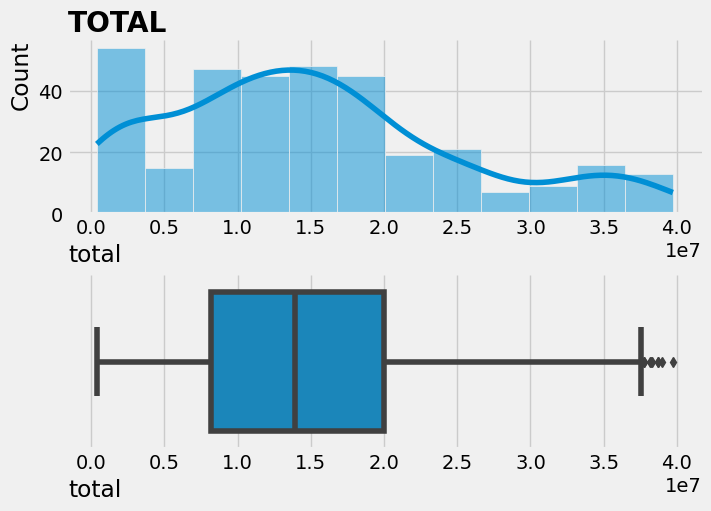

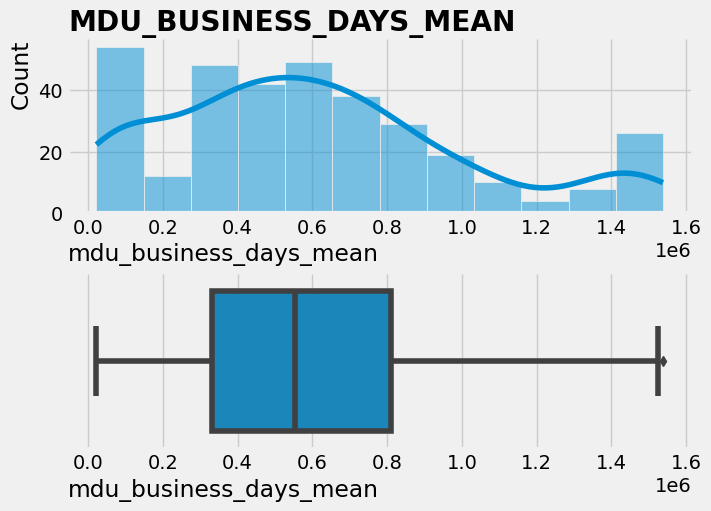

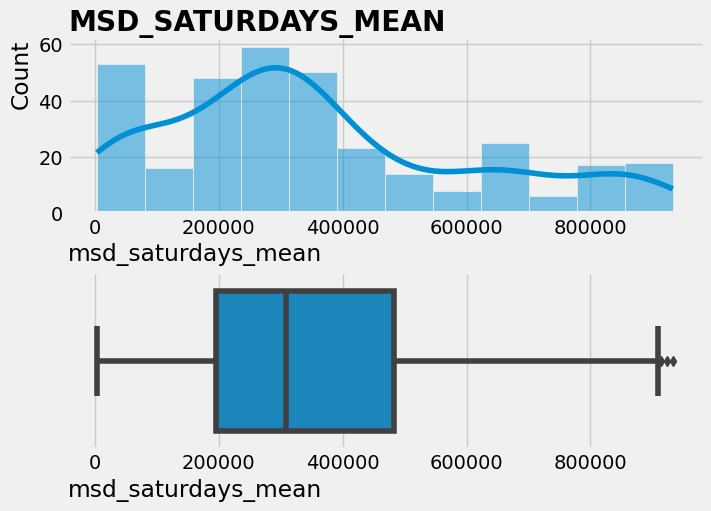

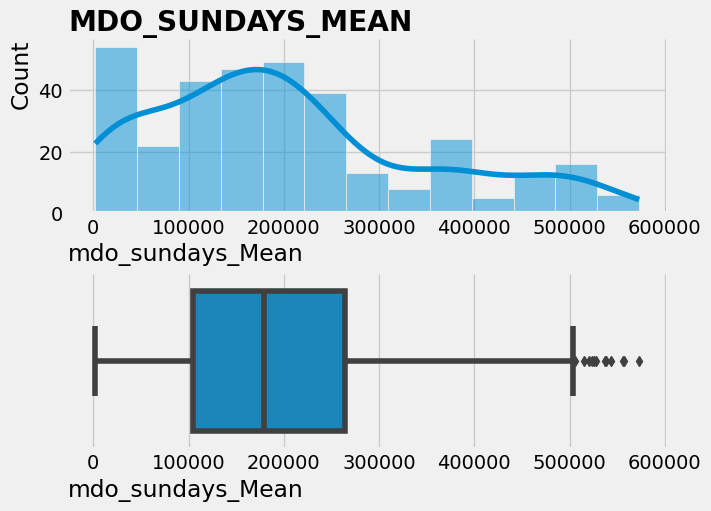

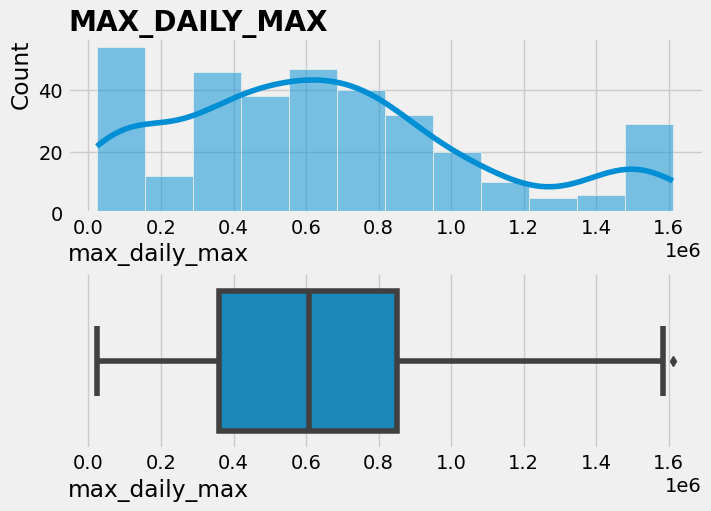

In [27]:
# iterate over numeric columns
for col in df_eda_num.columns.tolist():
    # create a figure object
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 5), constrained_layout=True)

    # plot histogram and boxplot
    sns.histplot(x=col, data=df_eda_num, kde=True, ax=axs[0])
    sns.boxplot(x=col, data=df_eda_num, ax=axs[1])
    # define plot details
    axs[0].set_title(f"{col.upper()}")
    plt.show()

### 5.2.2 - Categorical Columns

In [28]:
# iterate over categorical columns
for col in df_eda_str.columns.tolist():
    # create a figure object
    fig = plt.figure(figsize=(7, 5))

    # plot histogram and boxplot
    sns.barplot(x=col, data=df_eda_str)
    # define plot details
    plt.title(f"{col.upper()}")
    plt.show()

### 5.2.3 Datetime Columns

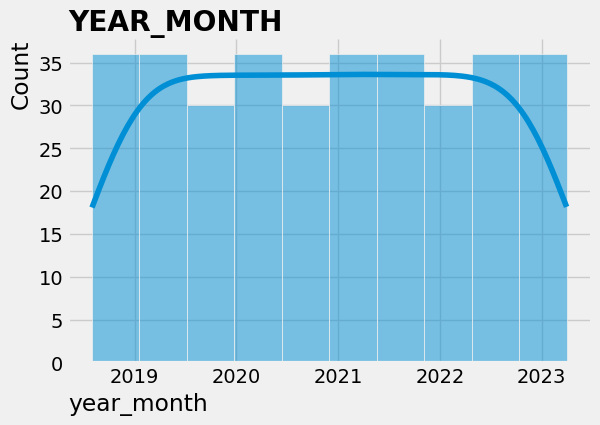

In [29]:
# iterate over numeric columns
for col in df_eda_date.columns.tolist():
    # create a figure object
    fig = plt.figure(figsize=(6, 4))
    # plot histogram and boxplot
    sns.histplot(x=col, data=df_eda_date, kde=True)
    # define plot details
    plt.title(f"{col.upper()}")
    plt.show()

## 5.3 - Bivariate Analysis

*Explore relationship between variables (in pairs)*

### 5.3.1 - Initial inspection

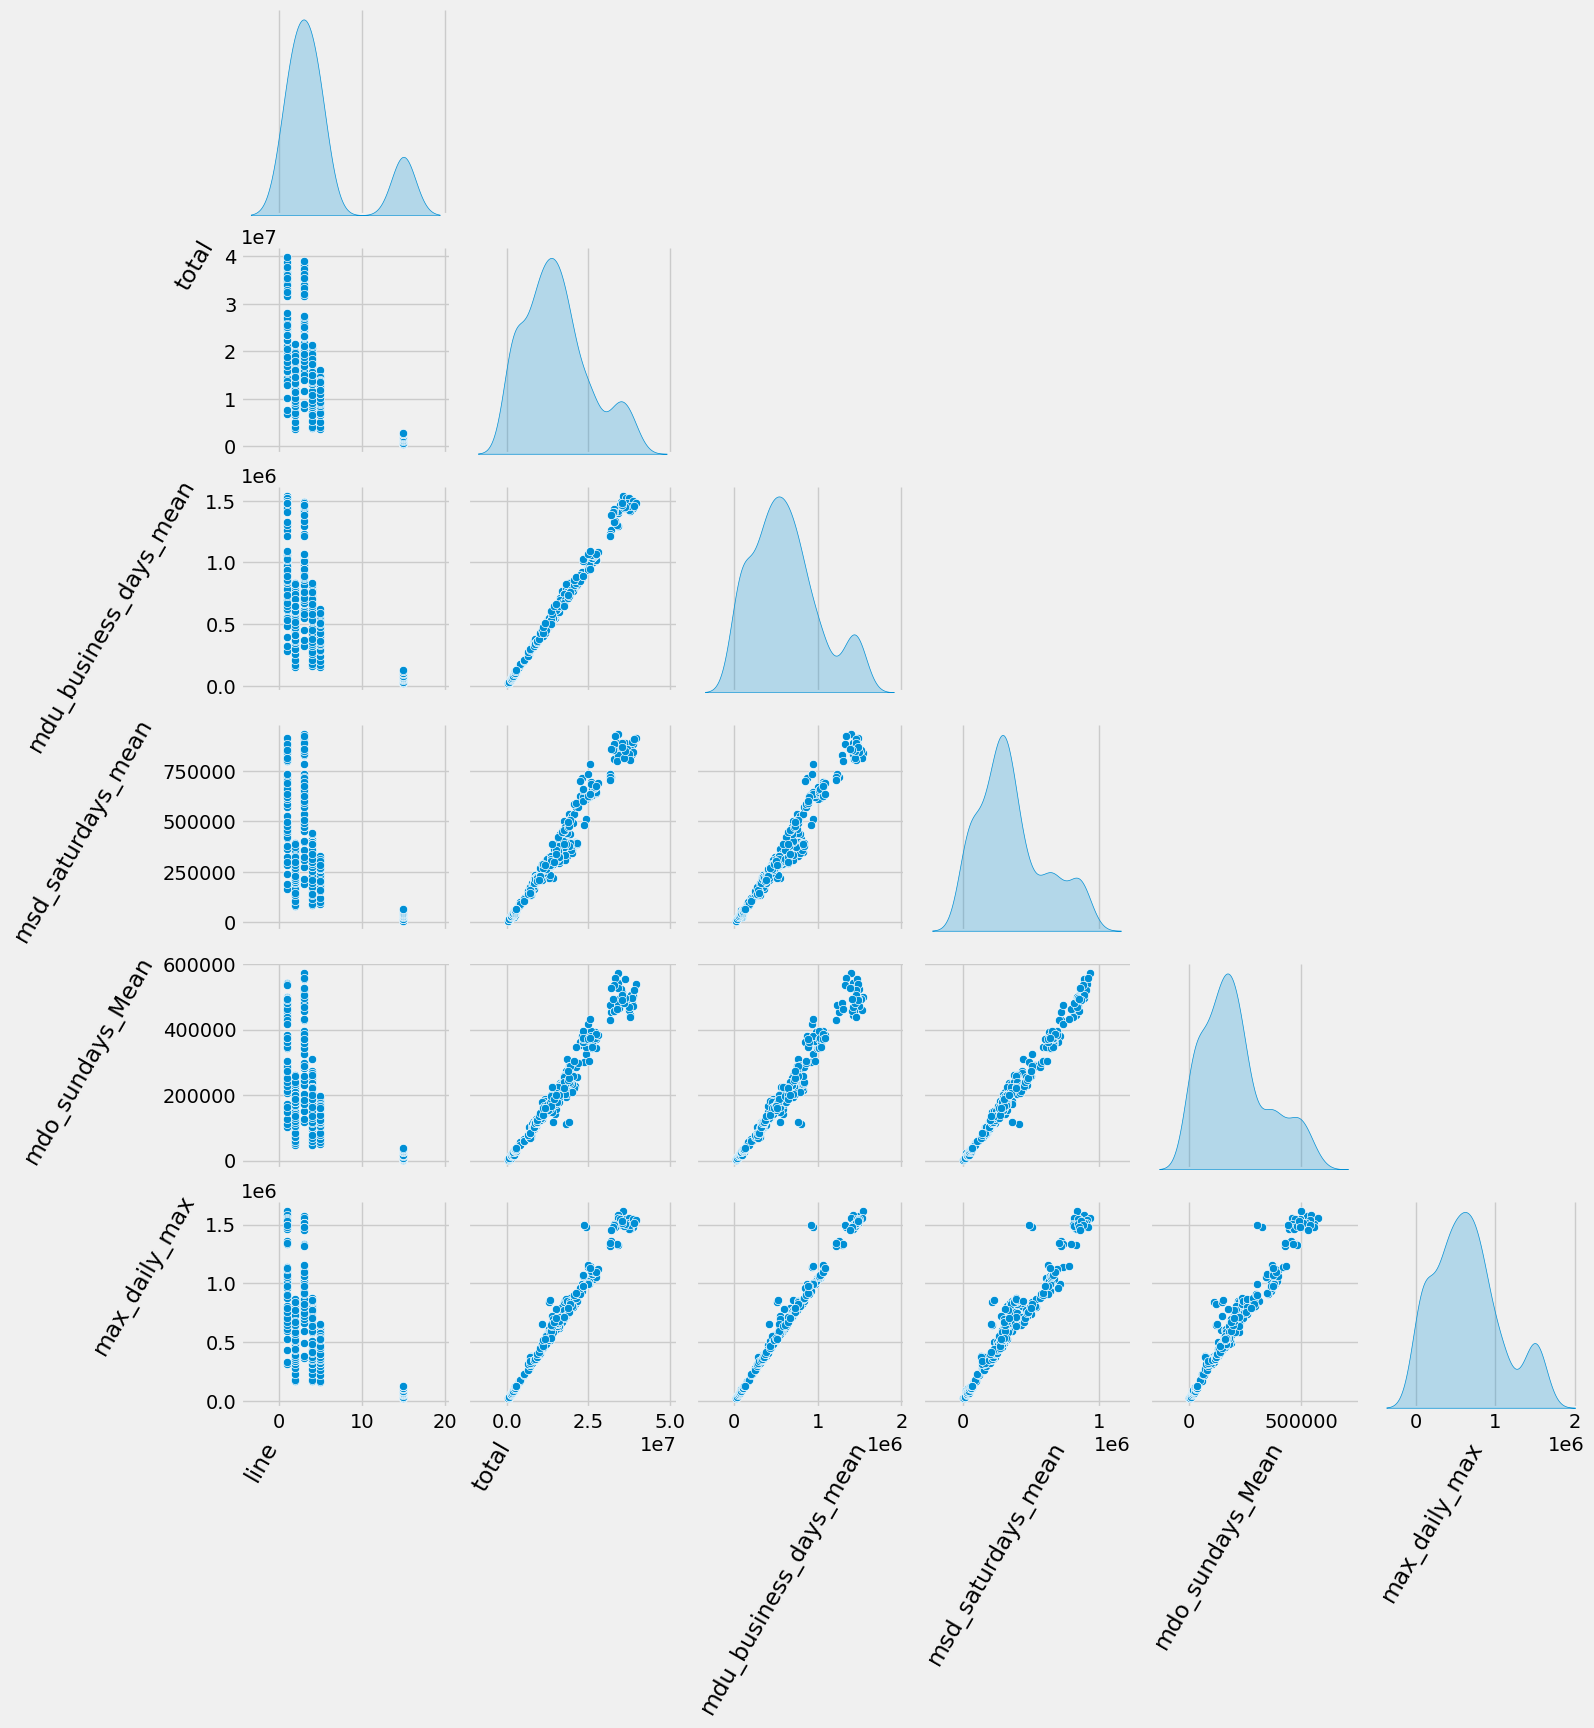

In [30]:
# plot pairplot
g = sns.pairplot(df_eda, diag_kind = "kde", corner=True);

# define plot details
for ax in g.axes.flatten():
    # try to rotate axis
    try:
        # rotate x axis labels
        ax.set_xlabel(ax.get_xlabel(), rotation = 60)
        # rotate y axis labels
        ax.set_ylabel(ax.get_ylabel(), rotation = 60)
        # set y labels alignment
        ax.yaxis.get_label().set_horizontalalignment('right')
    # errors due to ax is None
    except:
        # skip
        pass

### 5.3.2 - Numerical variables

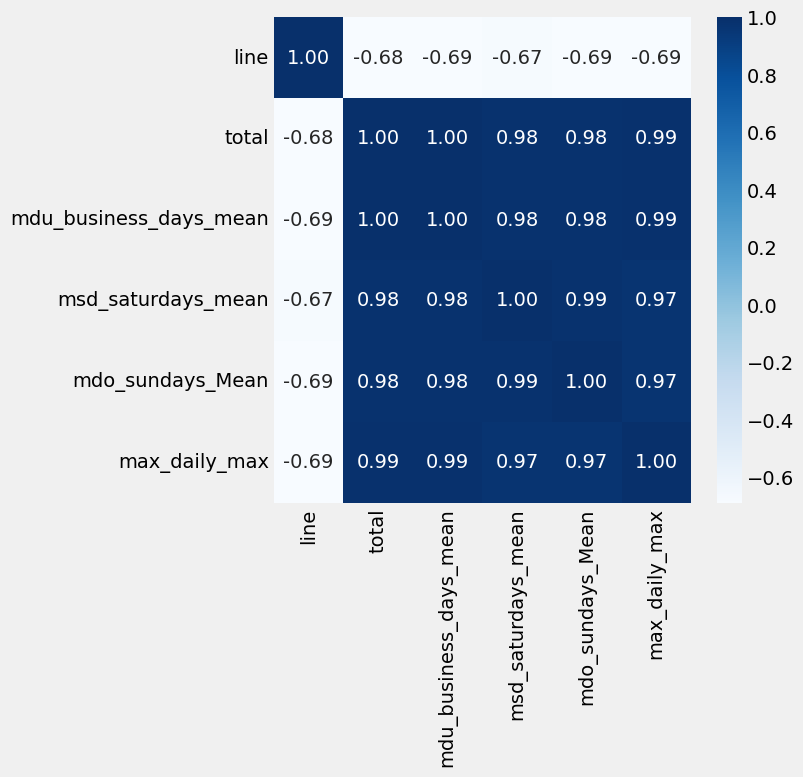

In [31]:
# calculate pearson correlation coefficient
correlation = df_eda_num.corr( method = 'spearman' )

# create figure and ax object
fig, ax = plt.subplots( figsize = (6, 6) )

# display heatmap of correlation on figure
sns.heatmap( correlation, annot = True, fmt=".2f", cmap="Blues")
plt.yticks( rotation = 0 );

### 5.3.3 - Categorical variables

In [32]:
# No categorical variable yet

## 5.4 - Business Hypothesis

*Validate all business hypothesis based on available data*

### **H1. ..**

### **H2. ..**

### **H3. ..**

### **H4. ..**

### **H5. ..**

## 5.5 - Time-series exploration

*Explore time-series variables*

In [33]:
# # iterate over columns
# for col in df_eda.columns[2:].tolist():

#     # chekc if column is not numeric
#     if not pd.api.types.is_numeric_dtype(df_eda[col].dtypes):
#         # skip to next column
#         continue

#     # print report
#     print(
#         f"{'*'*49}\n"
#         f"\t{col.upper()}\n"
#         f"{'*'*49}"
#     )

#     # get unique lines
#     unique_lines = df_eda["line"].unique().tolist()
#     unique_lines.sort()
    
#     # # iterate over available lines
#     # for line in [15]:#unique_lines:
#     # iterate over available lines
#     for line in unique_lines:

#         # filter to only a single line
#         df_line = df_eda.loc[df_eda["line"] == line, ["year_month", col]]

#         # create a new dataframe with year_month as index,
#         # dropping year_month from column
#         # and filling any missing data with linear interpolation
#         df_line = df_line.set_index("year_month", drop=True).interpolate(method="linear")
#         # fill any missing data at the begining of dataset (not able to interpolate)
#         # with backfill
#         df_line = df_line.fillna(method="backfill")

#         # Additive Decomposition (y = Trend + Seasonal + Residuals)
#         result_add = seasonal_decompose(df_line[col], model='additive', extrapolate_trend = "freq")
#         # # Multiplicative Decomposition (y = Trend * Seasonal * Residuals)
#         # result_mul = seasonal_decompose(df_line[col], model='multiplicative', extrapolate_trend = "freq")

#         # define plot details
#         result_add.plot()
#         g = plt.gcf()
#         g.set_size_inches(10, 7)
#         g.suptitle(f"Line: {line}; Additive model residuals\n")
#         plt.show()


## 5.6 - Causal Inference techniques

*Apply causal inference techniques to get insights*

### **Regression Discontinuity**

,year_month,total_mean,total_sum,missing_total,year_month_idx
0,2018-08-01,"20,533,000.000","123,198,000.000",0,0
1,2018-09-01,"18,661,833.333","111,971,000.000",0,1
2,2018-10-01,"20,864,333.333","125,186,000.000",0,2
3,2018-11-01,"19,436,000.000","116,616,000.000",0,3
4,2018-12-01,"18,984,666.667","113,908,000.000",0,4


,year_month,total_mean,total_sum,missing_total,year_month_idx
52,2022-12-01,"15,440,905.000","92,645,430.000",0,52
53,2023-01-01,"14,486,106.667","86,916,640.000",0,53
54,2023-02-01,"14,582,341.667","87,494,050.000",0,54
55,2023-03-01,"17,517,401.667","105,104,410.000",0,55
56,2023-04-01,"15,798,298.333","94,789,790.000",0,56


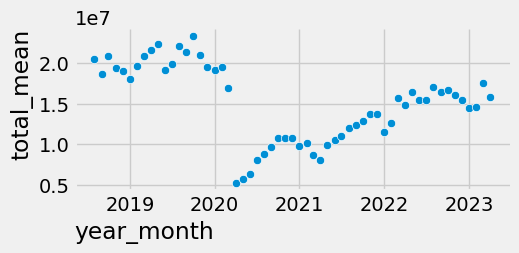

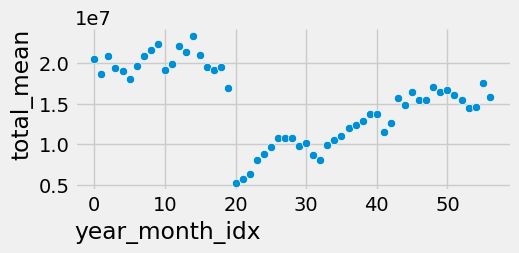

In [34]:
# filter required cokumns
df_causal = df_eda[["year_month", "total", "line"]]

# aggreagate total_mean_mean per year-month considering the mean as aggregation
df_causal_agg = df_causal.groupby(by=["year_month"], as_index=False).agg(
    total_mean = ("total", "mean"),
    total_sum = ("total", "sum"),
    missing_total = ("total", lambda x: np.sum(np.isnan(x)))
)

# create a new column with datetime index
df_causal_agg["year_month_idx"] = np.arange(start=0, stop=len(df_causal_agg), step=1)

# inspect results
display(df_causal_agg.head(), df_causal_agg.tail())

# inspect plots
plt.figure(figsize=(5, 2))
sns.scatterplot(data=df_causal_agg, x="year_month", y="total_mean")
plt.show()
plt.figure(figsize=(5, 2))
sns.scatterplot(data=df_causal_agg, x="year_month_idx", y="total_mean")
plt.show()

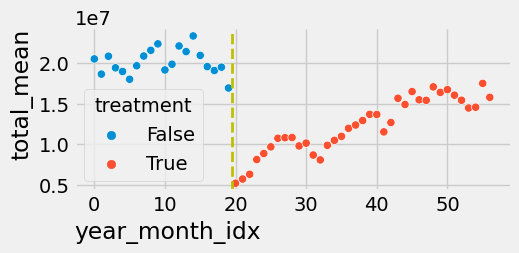

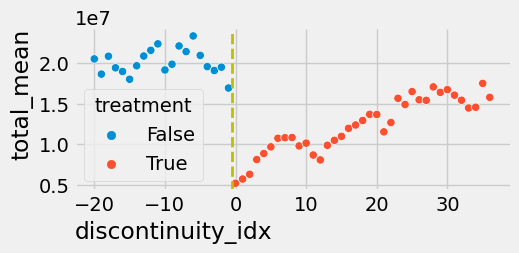

In [35]:
# create a new column where discontinuity is on index 0
df_causal_agg["discontinuity_idx"] = df_causal_agg["year_month_idx"] - 20
# create a new column to indicate if after discountinuity
df_causal_agg["treatment"] = df_causal_agg["discontinuity_idx"] >= 0

# inpect visualy
plt.figure(figsize=(5, 2))
sns.scatterplot(data=df_causal_agg, x="year_month_idx", y="total_mean", hue="treatment")
plt.axvline(19.5, color="y", linestyle="--", linewidth=2)
plt.show()
plt.figure(figsize=(5, 2))
sns.scatterplot(data=df_causal_agg, x="discontinuity_idx", y="total_mean", hue="treatment")
plt.axvline(-0.5, color="y", linestyle="--", linewidth=2)
plt.show()

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.017e+07,6.72e+05,30.006,0.000,1.88e+07,2.15e+07
treatment[T.True],-1.307e+07,8.18e+05,-15.977,0.000,-1.47e+07,-1.14e+07
discontinuity_idx,1356.7669,5.61e+04,0.024,0.981,-1.11e+05,1.14e+05
discontinuity_idx:treatment[T.True],2.883e+05,6.04e+04,4.775,0.000,1.67e+05,4.09e+05



Treatment impact: -13,072,162



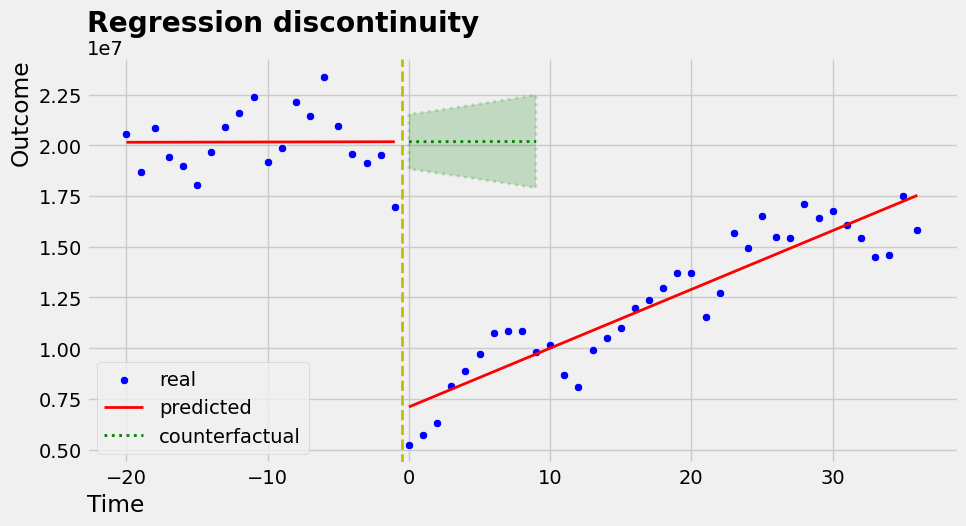

In [36]:
# use OLS to infer causality by means of coefficients
model = smf.wls("total_mean ~ discontinuity_idx * treatment", df_causal_agg).fit()
# inspect results
display(model.summary().tables[1])

# check for statistical significance
if model.pvalues["treatment[T.True]"] < 0.05:
    # print report
    print(
        f'\nTreatment impact: {int(model.params["treatment[T.True]"]):,}\n'
    )

# create a new column with predictions
df_causal_agg["predictions"] = model.predict()

# create a copy of dataframe
df_causal_agg_counterfactual = df_causal_agg[["discontinuity_idx", "treatment"]].copy()
# filter where where there were treatment
df_causal_agg_counterfactual = df_causal_agg_counterfactual[df_causal_agg_counterfactual["treatment"]]
# assign treatment to zero 
df_causal_agg_counterfactual["treatment"] = False
# make predictions
df_causal_agg_counterfactual["counterfactual_predictions"] = model.get_prediction(exog=df_causal_agg_counterfactual).predicted_mean
df_causal_agg_counterfactual[
    ["counterfactual_predictions_lower_ci", "counterfactual_predictions_upper_ci"]
    ] = model.get_prediction(exog=df_causal_agg_counterfactual).conf_int()

# plot original data as well as predictions
ax = sns.scatterplot(data=df_causal_agg, x="discontinuity_idx", y="total_mean", color="b", label="real")
sns.lineplot(data=df_causal_agg[df_causal_agg["discontinuity_idx"]<0], 
             x="discontinuity_idx", y="predictions", color="r", ax=ax, label="predicted", 
             linestyle="-", linewidth=2)
sns.lineplot(data=df_causal_agg[df_causal_agg["discontinuity_idx"]>=0], 
             x="discontinuity_idx", y="predictions", color="r", ax=ax, #label="predicted",
             linestyle="-", linewidth=2)
sns.lineplot(data=df_causal_agg_counterfactual.head(10), 
             x="discontinuity_idx", y="counterfactual_predictions", color="g", ax=ax, label="counterfactual",
             linestyle=":", linewidth=2)
ax.fill_between(
    x=df_causal_agg_counterfactual["discontinuity_idx"].head(10), 
    y1=df_causal_agg_counterfactual["counterfactual_predictions_lower_ci"].head(10), 
    y2=df_causal_agg_counterfactual["counterfactual_predictions_upper_ci"].head(10), 
    color="g", linestyle=":", linewidth=2, alpha=0.2
    )
# plot details
plt.axvline(-0.5, color="y", linestyle="--", linewidth=2)
plt.title("Regression discontinuity")
plt.ylabel("Outcome")
plt.xlabel("Time")
plt.legend(loc="lower left");

#### **Create a kernel to emphasize data points closer to discontinuity**

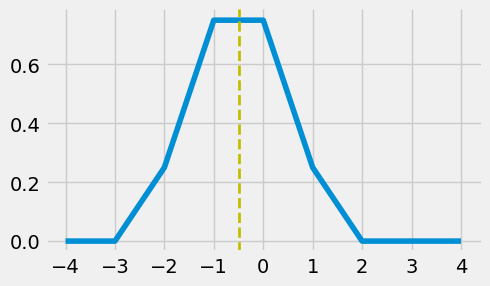

In [37]:
def triangular_kernel(R: np.ndarray, c: float, h:float) -> np.ndarray:
    """
    Apply a triangular kernel on the running array R
    given the center parameter 'c' and the width parameter 'h'

    Args
        R: np.ndarray with the running variable
        c: float with a center parameter
        h: float with a width parameter
        
    Return
       np.ndarray with the triangular kernel applied
       
    NOTE:
        The width parameter of the kernel can change the regression line by a lot. 
        The lower the width, the less we consider points far from the threshold.        
    """
    return 1*(np.abs(R - c) <= h) * (1 - np.abs(R - c)/h)


# define array to test
test_array = np.arange(-4, 5, 1, dtype=float)
# define c value
c = -0.5
kernel_array = triangular_kernel(test_array, c=c, h=2)

# inspect resutls
fig = plt.figure(figsize=(5, 3))
plt.plot(test_array, kernel_array)
plt.axvline(c, color="y", linestyle="--", linewidth=2)
plt.xticks(test_array);

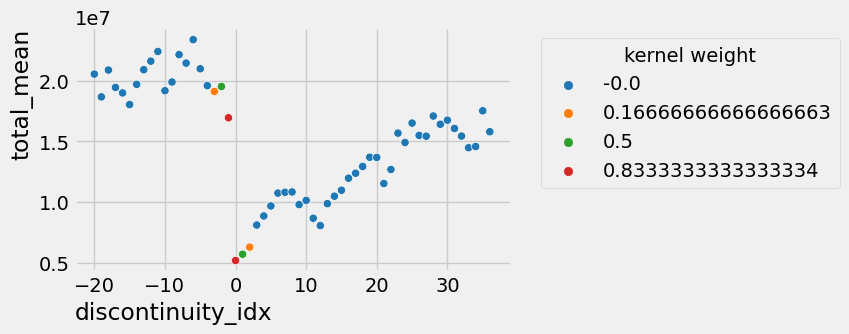

In [38]:
# apply kernel on centered year_month_idx
df_causal_agg["kernel_weight"] = triangular_kernel(R=df_causal_agg["discontinuity_idx"], c=-0.5, h=3)

# inspect results
plt.figure(figsize=(5, 3))
sns.scatterplot(data=df_causal_agg, x="discontinuity_idx", y="total_mean", hue="kernel_weight", palette="tab10")
plt.legend(title="kernel weight", bbox_to_anchor=(1.05, 1));

/home/ds-gustavo-cunha/.pyenv/versions/omdena_sp_train/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:807: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.563e+07,2.13e+05,73.354,0.000,1.52e+07,1.61e+07
treatment[T.True],-1.042e+07,2.4e+05,-43.404,0.000,-1.09e+07,-9.94e+06
discontinuity_idx,-1.552e+06,1.25e+05,-12.379,0.000,-1.8e+06,-1.3e+06
discontinuity_idx:treatment[T.True],2.092e+06,1.77e+05,11.799,0.000,1.74e+06,2.45e+06



Treatment impact: -10,418,566



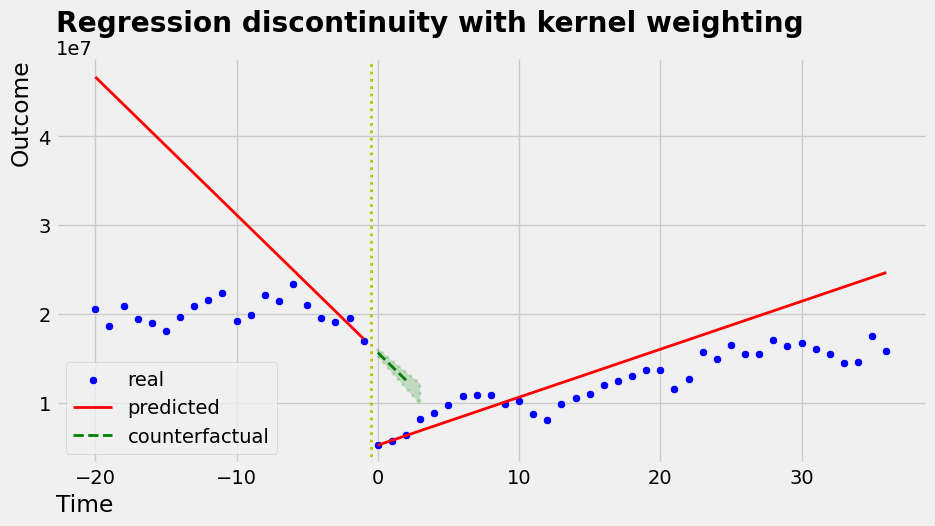

In [39]:
# use OLS to infer causality by means of coefficients
model = smf.wls("total_mean ~ discontinuity_idx * treatment", 
                data=df_causal_agg,
                weights=df_causal_agg["kernel_weight"]).fit()

# inspect results
display(model.summary().tables[1])

# check for statistical significance
if model.pvalues["treatment[T.True]"] < 0.05:
    # print report
    print(
        f'\nTreatment impact: {int(model.params["treatment[T.True]"]):,}\n'
    )

# create a new column with predictions
df_causal_agg["predictions"] = model.predict()

# create a copy of dataframe
df_causal_agg_counterfactual = df_causal_agg[["discontinuity_idx", "treatment"]].copy()
# filter where where there were treatment
df_causal_agg_counterfactual = df_causal_agg_counterfactual[df_causal_agg_counterfactual["treatment"]]
# assign treatment to zero 
df_causal_agg_counterfactual["treatment"] = False
# make predictions
df_causal_agg_counterfactual["counterfactual_predictions"] = model.get_prediction(exog=df_causal_agg_counterfactual).predicted_mean
df_causal_agg_counterfactual[
    ["counterfactual_predictions_lower_ci", "counterfactual_predictions_upper_ci"]
    ] = model.get_prediction(exog=df_causal_agg_counterfactual).conf_int()

# plot original data as well as predictions
ax = sns.scatterplot(data=df_causal_agg, x="discontinuity_idx", y="total_mean", color="b", label="real")
sns.lineplot(data=df_causal_agg[df_causal_agg["discontinuity_idx"]<0], 
             x="discontinuity_idx", y="predictions", color="r", ax=ax, label="predicted", 
             linestyle="-", linewidth=2)
sns.lineplot(data=df_causal_agg[df_causal_agg["discontinuity_idx"]>=0], 
             x="discontinuity_idx", y="predictions", color="r", ax=ax, #label="predicted",
             linestyle="-", linewidth=2)
sns.lineplot(data=df_causal_agg_counterfactual.head(3), 
             x="discontinuity_idx", y="counterfactual_predictions", color="g", ax=ax, label="counterfactual",
             linestyle="--", linewidth=2)
ax.fill_between(
    x=df_causal_agg_counterfactual["discontinuity_idx"].head(4), 
    y1=df_causal_agg_counterfactual["counterfactual_predictions_lower_ci"].head(4), 
    y2=df_causal_agg_counterfactual["counterfactual_predictions_upper_ci"].head(4), 
    color="g", linestyle=":", linewidth=2, alpha=0.2
    )
# plot details
plt.axvline(-0.5, color="y", linestyle=":", linewidth=2)
plt.title("Regression discontinuity with kernel weighting")
plt.ylabel("Outcome")
plt.xlabel("Time")
plt.legend(loc="lower left");

### **Interupted Time-Series**


ADF test p-value: 0.352



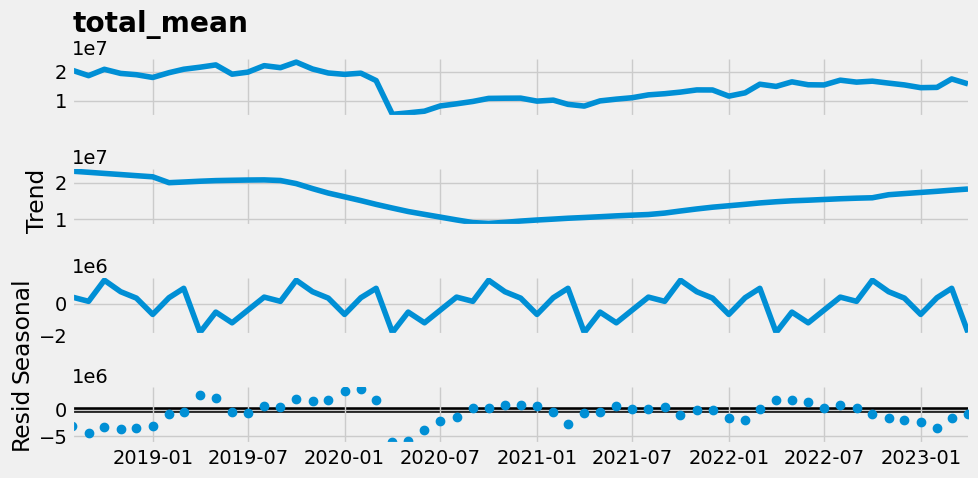

In [40]:
# filter required cokumns
df_its = df_eda[["year_month", "total", "line"]]

# aggreagate total_mean per year-month considering the mean as aggregation
df_its = df_its.groupby(by=["year_month"], as_index=False).agg(
    total_mean = ("total", "mean"),
    total_sum = ("total", "sum"),
    missing_total = ("total", lambda x: np.sum(np.isnan(x)))
)

# reset indet
df_its = df_its.set_index("year_month", drop=True)

# Additive Decomposition (y = Trend + Seasonal + Residuals)
result_add = seasonal_decompose(df_its["total_mean"], model='additive', extrapolate_trend = "freq")

# print report about residual
print(
    # perform Augmented Dickey Fuller - ADF to check for stationarity
    # H0: The series is not-stationary
    f"\nADF test p-value: {adfuller(df_its['total_mean'])[1]:.3f}\n"
)

# plot seasonal decomposition
result_add.plot();


ADF test p-value on diff=1: 0.000



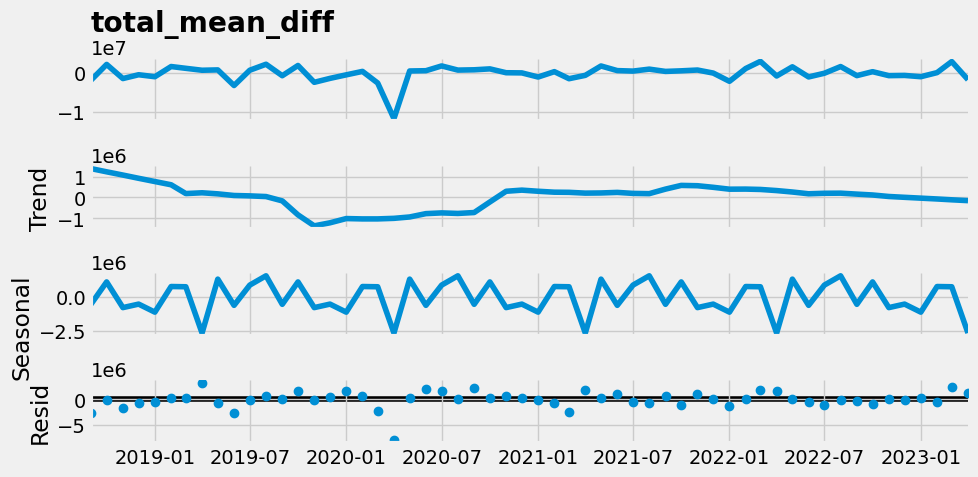

In [41]:
# filter required cokumns
df_its_diff = df_eda[["year_month", "total", "line"]]

# aggreagate total_mean per year-month considering the mean as aggregation
df_its_diff = df_its_diff.groupby(by=["year_month"], as_index=False).agg(
    total_mean = ("total", "mean")
)

# reset indet
df_its_diff = df_its_diff.set_index("year_month", drop=True)

# differentiate time-series
df_its_diff["total_mean_diff"] = df_its_diff["total_mean"].diff(1)
# remove NaNs
df_its_diff = df_its_diff.dropna(how="any", axis="index")

# Additive Decomposition (y = Trend + Seasonal + Residuals)
result_add = seasonal_decompose(df_its_diff["total_mean_diff"], model='additive', extrapolate_trend = "freq")

# print report about residual
print(
    # perform Augmented Dickey Fuller - ADF to check for stationarity
    # H0: The series is not-stationary
    f"\nADF test p-value on diff=1: {adfuller(df_its_diff['total_mean_diff'])[1]:.3f}\n"
)

# plot seasonal decomposition
result_add.plot();

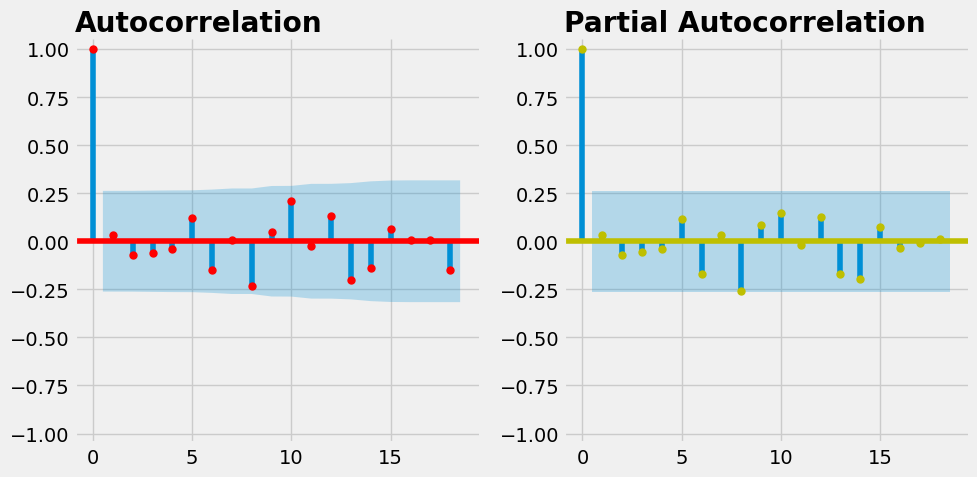

In [42]:
# define plot details
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), tight_layout=True)

# plot acf and padf
plot_acf(df_its_diff['total_mean_diff'], c="r", zero=True, ax=axs[0])
plot_pacf(df_its_diff['total_mean_diff'], c="y", zero=True, ax=axs[1])
# plot details
axs[0].set_ylim(-1.05, 1.05)
axs[1].set_ylim(-1.05, 1.05)
plt.show()

In [43]:
# # Define Auto-ARIMA to automatically discover the optimal order for an ARIMA model.
# auto_model = pm.auto_arima(
#     y=df_its['total_mean_diff'],
#     start_p=0, max_p=2,
#     d=0, max_d=1, 
#     start_q=0, max_q=2,
#     start_P=0, max_P=2, 
#     D=1, max_D=1,
#     start_Q=0, max_Q=2,
#     max_order=5, 
#     seasonal=True, m=12, # yearly seasonality
#     trend=None, with_intercept="auto",
#     scoring="mae",
#     trace=False, 
#     error_action="ignore", suppress_warnings=True, 
#     n_jobs=-1
#     )

# # try to train model
# try:
#     # fit mode to data
#     auto_model.fit()

# # in case of type error    
# except TypeError:
#     pass

# # regardless of errors
# finally:
#    # inspect results
#     display(auto_model.summary())

In [44]:
# # inspect best params
# auto_model.params

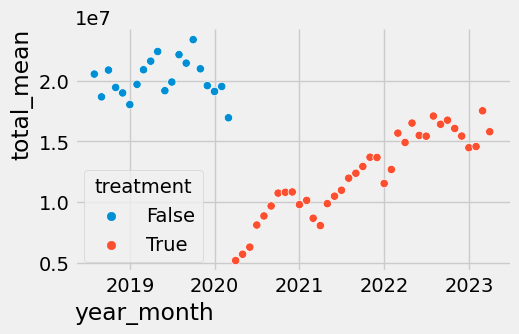

In [45]:
# create a new column with indexes since beginning
df_its["idx_since_beginning"] = np.arange(start=0, stop=len(df_its), step=1)

# define treatment index
t_idx = 19

# create a column to indicate treatment
df_its["treatment"] = df_its["idx_since_beginning"] > t_idx

# create a new column where before intervention = 0, after intervention = time since intervention
df_its["idx_since_intervention"] = np.where(
    df_its["treatment"] > 0, 
    df_its["idx_since_beginning"] - t_idx, 
    0
)

# inspect data
f = plt.figure(figsize=(5, 3))
sns.scatterplot(data=df_its, x=df_its.index, y="total_mean", hue="treatment");

In [46]:
# convert treatment to numeric
df_its["treatment"] = df_its["treatment"].astype(int)

# inspect data
df_its

,total_mean,total_sum,missing_total,idx_since_beginning,treatment,idx_since_intervention
year_month,,,,,,
2018-08-01,"20,533,000.000","123,198,000.000",0,0,0,0
2018-09-01,"18,661,833.333","111,971,000.000",0,1,0,0
2018-10-01,"20,864,333.333","125,186,000.000",0,2,0,0
2018-11-01,"19,436,000.000","116,616,000.000",0,3,0,0
2018-12-01,"18,984,666.667","113,908,000.000",0,4,0,0
2019-01-01,"18,028,166.667","108,169,000.000",0,5,0,0
2019-02-01,"19,688,666.667","118,132,000.000",0,6,0,0
2019-03-01,"20,889,833.333","125,339,000.000",0,7,0,0
2019-04-01,"21,594,500.000","129,567,000.000",0,8,0,0


In [47]:
# define sarima training params
training_params = dict(
    order=(0, 1, 0),
    trend=None, 
    #seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False, 
    enforce_invertibility=False,
    missing="drop"
)

In [48]:
# train arima
sarimax = ARIMA(
    endog=df_its[["total_mean"]],
    exog=df_its[[
        # "idx_since_beginning", 
        "treatment", 
        "idx_since_intervention"
    ]],
    **training_params
).fit()

# inspect results
display(sarimax.summary().tables[1])

# check for statistical significance
if sarimax.pvalues["treatment"] < 0.05:
    # print report
    print(
        f'\nTreatment impact: {int(sarimax.params["treatment"]):,}\n'
    )

/home/ds-gustavo-cunha/.pyenv/versions/omdena_sp_train/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/ds-gustavo-cunha/.pyenv/versions/omdena_sp_train/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/ds-gustavo-cunha/.pyenv/versions/omdena_sp_train/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,coef,std err,z,P>|z|,[0.025,0.975]
treatment,-1.202e+07,3827.558,-3141.209,0.000,-1.2e+07,-1.2e+07
idx_since_intervention,2.94e+05,1.44e+07,0.020,0.984,-2.79e+07,2.85e+07
sigma2,1.001e+14,2.75e+13,3.644,0.000,4.62e+13,1.54e+14



Treatment impact: -12,023,158



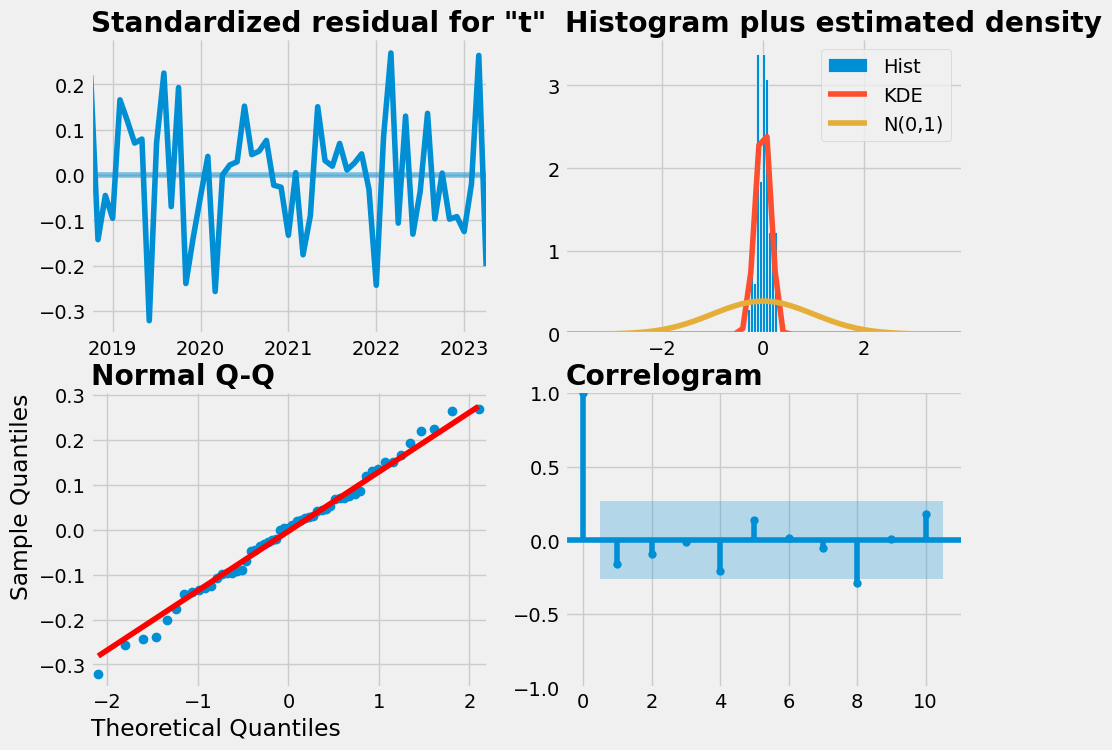

In [49]:
# plot model diagnostics
sarimax.plot_diagnostics(figsize=(10, 8));

In [50]:
# create a new column with predictions and residuals
df_its["predictions"] = sarimax.predict()
df_its["residuals"] = sarimax.resid

# inspect results
df_its

,total_mean,total_sum,missing_total,idx_since_beginning,treatment,idx_since_intervention,predictions,residuals
year_month,,,,,,,,
2018-08-01,"20,533,000.000","123,198,000.000",0,0,0,0,0.000,"20,533,000.000"
2018-09-01,"18,661,833.333","111,971,000.000",0,1,0,0,"20,533,000.000","-1,871,166.667"
2018-10-01,"20,864,333.333","125,186,000.000",0,2,0,0,"18,661,833.333","2,202,500.000"
2018-11-01,"19,436,000.000","116,616,000.000",0,3,0,0,"20,864,333.333","-1,428,333.333"
2018-12-01,"18,984,666.667","113,908,000.000",0,4,0,0,"19,436,000.000","-451,333.333"
2019-01-01,"18,028,166.667","108,169,000.000",0,5,0,0,"18,984,666.667","-956,500.000"
2019-02-01,"19,688,666.667","118,132,000.000",0,6,0,0,"18,028,166.667","1,660,500.000"
2019-03-01,"20,889,833.333","125,339,000.000",0,7,0,0,"19,688,666.667","1,201,166.667"
2019-04-01,"21,594,500.000","129,567,000.000",0,8,0,0,"20,889,833.333","704,666.667"


In [51]:
# filter where where there were treatment
df_its_counterfactual = df_its.loc[
    df_its["treatment"] == 0,
    ["total_mean"],
].copy()

# train sarima
sarimax_counterfactual = ARIMA(
    endog=df_its_counterfactual[["total_mean"]],
    # exog=df_its_counterfactual[[
    #     # "idx_since_beginning", 
    #     "treatment", 
    #     "idx_since_intervention"
    # ]],
    **training_params
).fit()

# make predictions
df_its_counterfactual["predictions"] = sarimax.predict()
df_its_counterfactual["residuals"] = sarimax.resid

# inspect results
df_its_counterfactual

/home/ds-gustavo-cunha/.pyenv/versions/omdena_sp_train/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/ds-gustavo-cunha/.pyenv/versions/omdena_sp_train/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/ds-gustavo-cunha/.pyenv/versions/omdena_sp_train/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,total_mean,predictions,residuals
year_month,,,
2018-08-01,"20,533,000.000",0.000,"20,533,000.000"
2018-09-01,"18,661,833.333","20,533,000.000","-1,871,166.667"
2018-10-01,"20,864,333.333","18,661,833.333","2,202,500.000"
2018-11-01,"19,436,000.000","20,864,333.333","-1,428,333.333"
2018-12-01,"18,984,666.667","19,436,000.000","-451,333.333"
2019-01-01,"18,028,166.667","18,984,666.667","-956,500.000"
2019-02-01,"19,688,666.667","18,028,166.667","1,660,500.000"
2019-03-01,"20,889,833.333","19,688,666.667","1,201,166.667"
2019-04-01,"21,594,500.000","20,889,833.333","704,666.667"


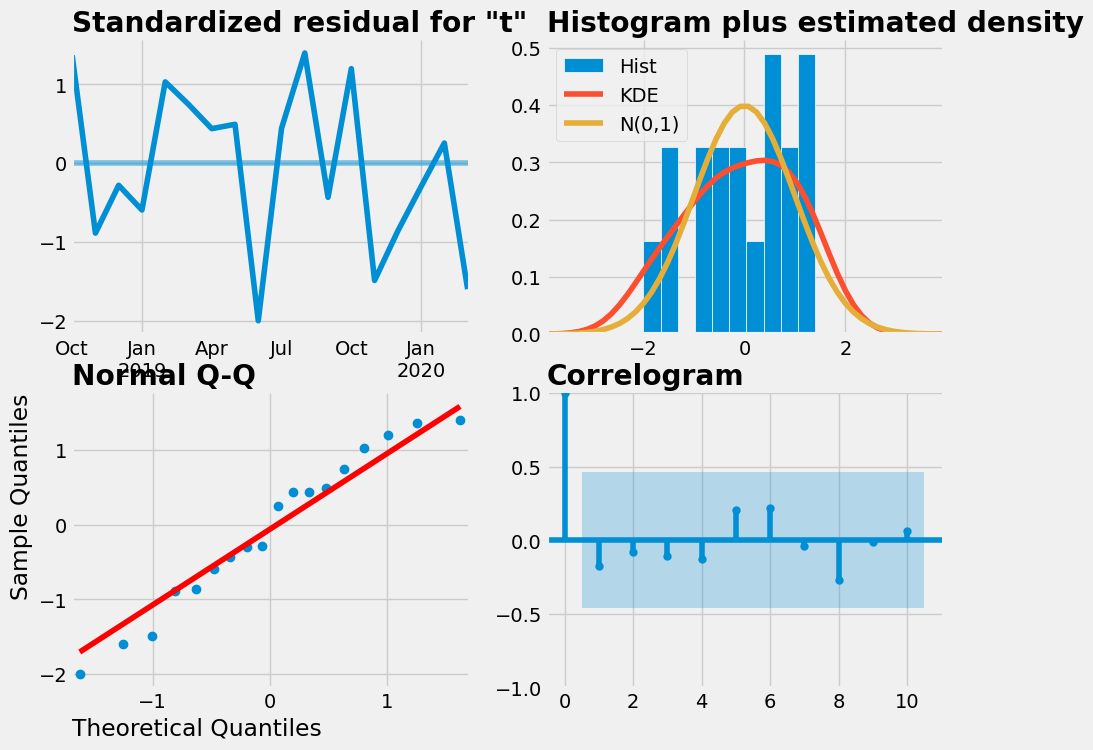

In [52]:
# plot model diagnostics
sarimax_counterfactual.plot_diagnostics(figsize=(10, 8));

In [53]:
# define forecasting window
forecast_window = 3

# get counterfactual forecasts
df_sarimax_counterfactual_forecast = sarimax_counterfactual.get_forecast(steps=forecast_window).predicted_mean.to_frame()
df_sarimax_counterfactual_forecast_ci = sarimax_counterfactual.get_forecast(
    steps=forecast_window
    ).conf_int().rename(columns={"lower total_mean": "counterfactual_forecast_lower_ci", "upper total_mean": "counterfactual_forecast_upper_ci"})

# inspect results
display(df_sarimax_counterfactual_forecast, df_sarimax_counterfactual_forecast_ci)

,predicted_mean
2020-04-01,"16,945,000.000"
2020-05-01,"16,945,000.000"
2020-06-01,"16,945,000.000"


,counterfactual_forecast_lower_ci,counterfactual_forecast_upper_ci
2020-04-01,"13,795,352.719","20,094,647.281"
2020-05-01,"12,490,726.099","21,399,273.901"
2020-06-01,"11,489,650.884","22,400,349.116"


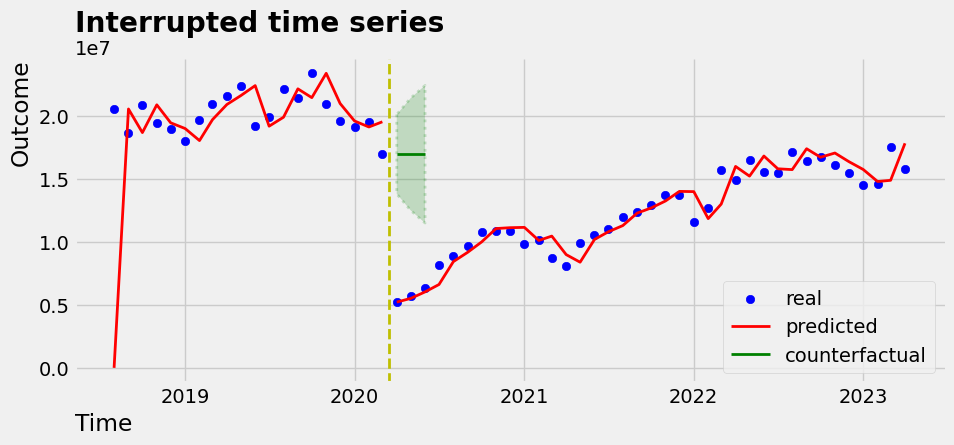

In [54]:
# define figure
f, axs = plt.subplots(figsize=(10, 4))

# plot real data
plt.scatter(x=df_its.index, y=df_its["total_mean"], color="b", label="real")
# plot in-sample predictions before treatment
plt.plot(df_its[df_its["idx_since_beginning"]<=t_idx]["predictions"], 
         color="r", label="predicted", 
         linestyle="-", linewidth=2)
# plot in-sample predictions after treatment
plt.plot(df_its[df_its["idx_since_beginning"]>t_idx]["predictions"], 
         color="r", 
         linestyle="-", linewidth=2)
# plot predictions
plt.plot(df_sarimax_counterfactual_forecast["predicted_mean"], 
         color="g", label="counterfactual",  
         linestyle="-", linewidth=2)
plt.fill_between(
    x=df_sarimax_counterfactual_forecast_ci.index, 
    y1=df_sarimax_counterfactual_forecast_ci["counterfactual_forecast_lower_ci"], 
    y2=df_sarimax_counterfactual_forecast_ci["counterfactual_forecast_upper_ci"], 
    color="g", linestyle=":", linewidth=2, alpha=0.2
    )

# plot details
plt.axvline(pd.to_datetime("2020-03-15", format="%Y-%m-%d"), color="y", linestyle="--", linewidth=2)
plt.title("Interrupted time series")
plt.ylabel("Outcome")
plt.xlabel("Time")
plt.legend(loc="lower right");

# **6 - DATA PREPARATION**

## 6.1 - Restore Point

*Create a checkpoint of the last dataframe from previous section*

In [ ]:
# create a restore point for the previous section dataframe
df_prep = df_eda.copy()

# check dataframe
df_prep

## 6.2 - Remove variables that won't be available in the production environment

*Remove variables that model can use on production to make predictions*

In [ ]:
# No need for this first iteration

## 6.3 - Train-Validation-Test split

*Split dataframe into training, validation and test dataset*

In [ ]:
# No need for this first iteration

## 6.4 - Scale numeric features

*Scale numeric feature to make modelling "easier" for ML models*

### 6.4.1 - Standard Scaler

In [ ]:
# No need for this first iteration

### 6.4.2 - Min-Max Scaler

In [ ]:
# No need for this first iteration

### 6.4.3 - Robust Scaler

In [ ]:
# No need for this first iteration

### 6.4.4 - Discretization

In [ ]:
# No need for this first iteration

## 6.5 - Encode categorical features

*Encode categorical feature to make modelling possible for ML models*

### 6.5.1 - One-Hot Encodingm

In [ ]:
# No need for this first iteration

### 6.5.2 - Ordinal Encoding

In [ ]:
# No need for this first iteration

### 6.5.3 - Target Encoding

In [ ]:
# No need for this first iteration

## 6.6 - Response variable transformation

*Transform target variable (e.g. log, sqrt, etc) to make modelling "easier" for ML models*

In [ ]:
# No need for this first iteration

## 6.7 - Cyclic variables transformation

*Transform cyclic variables (e.g. days of week, months in year, etc) with a sin and cos functions*

In [ ]:
# No need for this first iteration

## 6.8 - Double-check preparation

*Double-check the prepared dataset to make sure it is as expected*

In [ ]:
# No need for this first iteration

# **7 - FEATURE SELECTION**

## 7.1 - Restore Point

*Create a checkpoint of the last dataframe from previous section*

In [ ]:
# create a restore point for the previous section dataframe
df_f_selection = df_prep.copy()

# check dataframe
df_f_selection

## 7.2 - Logist regression coefficients

In [ ]:
# No need for this first iteration

## 7.3 - Random forest feature importance

In [ ]:
# No need for this first iteration

## 7.4 - Boruta algorithm

In [ ]:
# No need for this first iteration

## 7.5 - Mutual information

In [ ]:
# No need for this first iteration

# **8 - ML MODEL TRAINING**

## 8.1 - Restore Point

*Create a checkpoint of the last dataframe from previous section*

In [ ]:
# create a restore point for the previous section dataframe
df_train = df_f_selection.copy()

# check dataframe
df_train

## 8.2 - Metrics

*Define the metric of success and the health metrics*

**Metrics**
- Mean Error (ME)
- Mean Percentage Error (MPE)
- Mean Absolute Error (MAE)
- Mean Absolute Percentage Error (MAPE)
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- Root Mean Squared Logarithmix Error (RMSLE)

**Main metric**
- MAPE

**Health metrics**
- MPE
- MAE
- RMSE
- RMSLE

## 8.3 - Baseline model

*Check the performance metrics with a dummy model to get the baseline metric*

In [ ]:
# TO-DO

## 8.4 - ML models

*Get performance metrics of ML model with cross-validation*

### ARIMA

#### No differentiation

In [ ]:
# define column
col = "total"

# get unique lines
unique_lines = df_train["line"].unique().tolist()
unique_lines.sort()

# iterate over available lines
for line in unique_lines:
    # filter to only a single line
    df_line = df_train.loc[df_train["line"] == line, ["year_month", col]]

    # create a new dataframe with year_month as index,
    # dropping year_month from column
    # and filling any missing data with linear interpolation
    df_line = df_line.set_index("year_month", drop=True).interpolate(method="linear")
    # fill any missing data at the begining of dataset (not able to interpolate)
    # with backfill
    df_line = df_line.fillna(method="backfill")

    # Additive Decomposition (y = Trend + Seasonal + Residuals)
    result_add = seasonal_decompose(df_line[col], model='additive', extrapolate_trend = "freq")
    # Multiplicative Decomposition (y = Trend * Seasonal * Residuals)
    result_mul = seasonal_decompose(df_line[col], model='multiplicative', extrapolate_trend = "freq")

    # print report about residual
    print(
        f"ADF test for stationarity on feature TOTAL and line {line}\n"
        # perform Augmented Dickey Fuller - ADF to check for stationarity
        # H0: The series is not-stationary
        f"\tp-value for residuals on additive decomposition       {adfuller(df_line[col])[1]:.3f}\n"
        f"\tp-value for residuals on multiplicative decomposition {adfuller(df_line[col])[1]:.3f}"
    )
    # define plot details
    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 6), tight_layout=True)
    # define figure title
    fig.suptitle(f"feature: TOTAL; line {line}")

    # iterate over seasonal decompositions
    for idx, sd in enumerate(zip([result_add, result_mul], ["additive", "multiplicative"])):
        # plot seasonal decomposition
        axs[0, idx].set_title(f"{sd[1].upper()} decomposition")
        axs[0, idx].plot(sd[0].observed)
        axs[0, idx].set_ylabel("Observed")
        axs[1, idx].plot(sd[0].trend)
        axs[1, idx].set_ylabel("Trend")
        axs[2, idx].plot(sd[0].seasonal)
        axs[2, idx].set_ylabel("Seasonal")
        axs[3, idx].plot(sd[0].resid)
        axs[3, idx].set_ylabel("Residual")

    # display image
    plt.show()

#### With differentiation

In [ ]:
# define column of interest
col = "total"

# get unique lines
unique_lines = df_train["line"].unique().tolist()
unique_lines.sort()

# iterate over available lines
for line in unique_lines:
    # filter to only a single line
    df_line = df_train.loc[df_train["line"] == line, ["year_month", col]]

    # create a new dataframe with year_month as index,
    # dropping year_month from column
    # and filling any missing data with linear interpolation
    df_line = df_line.set_index("year_month", drop=True).interpolate(method="linear")
    # diferentiate time-series and remove any NAs
    df_line = df_line.diff(1).dropna(axis="index")
    
    # Additive Decomposition (y = Trend + Seasonal + Residuals)
    result_add = seasonal_decompose(df_line[col], model='additive', extrapolate_trend = "freq")
    # # Multiplicative Decomposition (y = Trend * Seasonal * Residuals)
    # HOWEVER, multiplicative seasonality is not appropriate for zero and negative values
    # result_mul = seasonal_decompose(df_line[col], model='multiplicative', extrapolate_trend = "freq")

    # print report about residual
    print(
        f"ADF test for stationarity on feature TOTAL and line {line}\n"
        # perform Augmented Dickey Fuller - ADF to check for stationarity
        # H0: The series is not-stationary
        f"\tp-value for residuals on additive decomposition and diff = 1      {adfuller(df_line[col])[1]:.3f}\n"
        # f"\tp-value for residuals on multiplicative decomposition {adfuller(result_mul.resid)[1]:.3f}"
    )
    # define plot details
    fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(12, 6), tight_layout=True)
    # define figure title
    fig.suptitle(f"feature: TOTAL; Differenciation: 1; line {line}")

    # plot seasonal decomposition
    axs[0].set_title(f"Additive decomposition")
    axs[0].plot(result_add.observed)
    axs[0].set_ylabel("Observed")
    axs[1].plot(result_add.trend)
    axs[1].set_ylabel("Trend")
    axs[2].plot(result_add.seasonal)
    axs[2].set_ylabel("Seasonal")
    axs[3].plot(result_add.resid)
    axs[3].set_ylabel("Residual")

    # display image
    plt.show()

In [ ]:
# get unique lines
unique_lines = df_train["line"].unique().tolist()
unique_lines.sort()

# iterate over available lines
for line in unique_lines:
    # filter to only a single line
    df_line = df_train.loc[df_train["line"] == line, ["year_month", col]]

    # create a new dataframe with year_month as index,
    # dropping year_month from column
    # and filling any missing data with linear interpolation
    df_line = df_line.set_index("year_month", drop=True).interpolate(method="linear")
    # diferentiate time-series and remove any NAs
    df_line = df_line.diff(1).dropna(axis="index")

    # define plot details
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), tight_layout=True)
    # define figure title
    fig.suptitle(f"feature: TOTAL; Differenciation: 1; line {line}")

    # plot acf and padf
    plot_acf(df_line, c="r", zero=True, ax=axs[0])
    plot_pacf(df_line, c="y", zero=True, ax=axs[1])
    # plot details
    axs[0].set_ylim(-0.5, 1.05)
    axs[1].set_ylim(-0.5, 1.05)
    plt.show()

**ARIMA**

In summary, initial guess is:

    p = 0, q = 0, d = 1

#### Experiment with a single line

In [ ]:
# define variables to inspect model 
col = "total"
lead_time = 3
forecast_horizon = 12
line = 1

# filter to only a single line
df_line = df_train.loc[df_train["line"] == line, ["year_month", col]]

# create a new dataframe with year_month as index,
# dropping year_month from column
# and filling any missing data with linear interpolation
df_line = df_line.set_index("year_month", drop=True).interpolate(method="linear")
    
# define training params
train_params = dict(
    exog=None, 
    order=(0, 1, 0), 
    seasonal_order=(0, 0, 0, 0), 
    enforce_stationarity=True, 
    missing="drop"
)

# split dataset
train = df_line.iloc[:-(lead_time+forecast_horizon)]
test = df_line.iloc[-(lead_time+forecast_horizon):]
        
# define ARIMA model
arima = ARIMA(
    endog=train, 
    **train_params
)    

# catch warnings with context manager
with warnings.catch_warnings():
    # ignore warning
    warnings.filterwarnings(action='ignore', module="statsmodels")
    # fit model to data
    arima = arima.fit()

# define plot layout
fig, axs = plt.subplots(1, 1, figsize=(12, 5))

# plot real and predicted values
axs.plot(df_line, label="real values")
axs.plot(arima.predict(start=None, end=None), label="in_sample")
plot_predict(arima, 
    start=len(train)+lead_time, end=len(train)+lead_time+forecast_horizon, # forecasting
    in_sample=True, label="predictions",ax=axs)
# plot details
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1));

#### Create experiments

In [ ]:
# # define target column 
# # and lead time
# col = "total"
# lead_time = 1
# forecast_horizon = 3

# # try to create experiment
# try:
#     # create MLFlow experiment
#     experiment_id = mlflow.create_experiment(
#         name="initial_time_series_experiment"
#         )
# # experiment already exist
# except mlflow.exceptions.MlflowException:
#     # create MLFlow experiment
#     experiment_id = mlflow.get_experiment_by_name(
#         name="initial_time_series_experiment"
#         ).experiment_id

# # get unique lines
# unique_lines = df_train["line"].unique().tolist()
# unique_lines.sort()

# # iterate over available lines
# for line in unique_lines:

#     # print report
#     print(f"On line {line} 🚀")

#     # filter to only a single line
#     df_line = df_train.loc[df_train["line"] == line, ["year_month", col]]

#     # create a new dataframe with year_month as index,
#     # dropping year_month from column
#     # and filling any missing data with linear interpolation
#     df_line = df_line.set_index("year_month", drop=True).interpolate(method="linear")
    
#     # define object to split data taking into account the order of dates
#     ts_cv = TimeSeriesSplit(n_splits=10, max_train_size=None, test_size=forecast_horizon, gap=lead_time)

#     # create a dict to store performance over different k folds
#     perform_dict = {
#         "mape": [],
#         "mpe": [],
#         "mae": [],
#         "rmse": [],
#         "rmsle": []
#     }

#     # define training params
#     train_params = dict(
#         exog=None, 
#         order=(0, 1, 0), 
#         seasonal_order=(0, 0, 0, 0), 
#         enforce_stationarity=True, 
#     )

#     # iterate over time series cv folds
#     for train_index, test_index in ts_cv.split(df_line):
#         # sanity check
#         assert train_index.max() < test_index.min(), "Mix of dates between train and test!"

#         # split dataset
#         train = df_line.iloc[train_index]
#         test = df_line.iloc[test_index]
        
#         # define ARIMA model
#         arima = ARIMA(
#             endog=train, 
#             **train_params
#         )    

#         # catch warnings with context manager
#         with warnings.catch_warnings():
#             # ignore warning
#             warnings.filterwarnings(action='ignore', module="statsmodels")
#             # fit model to data
#             arima = arima.fit()

#             # get predictions
#             pred = arima.forecast(steps=(lead_time+forecast_horizon))[lead_time:]

#         # concatenate predictions and real values
#         df_forecast = pd.concat(
#             objs=[pred, test], 
#             axis=1, join="inner", ignore_index=False
#             )

#         # get model results
#         performance = forecast_performance(forecast=df_forecast["predicted_mean"], actual=df_forecast["total"])

#         # iterate over metrics for kfolds
#         for k, v in performance.items():
#             # add metric to kfolds metrics
#             perform_dict[k].append(v)


#     # define MLFlow model tag
#     mlflow_model_tag = f"ARIMA[line={line}]({train_params['order']})({train_params['seasonal_order']})"

#     # make a run on MLFlow with context manager
#     with mlflow.start_run(
#         experiment_id=experiment_id, 
#         run_name=mlflow_model_tag, 
#         tags={
#             "experiment_type": "time_series_forecasting",
#             "model": "ARIMA"
#         }):

#         # select active run
#         run = mlflow.active_run()
#         # report run status
#         print(f"\texperiment_id: {experiment_id}; run_id: {run.info.run_id}; status: {run.info.status}")

#         # calculate mean and std performance metrics over all kfolds
#         perform_mean_dict = {k: np.mean(v) for k, v in perform_dict.items()}      
#         perform_std_dict = {k: np.std(v, ddof=1) for k, v in perform_dict.items()}      

#         # log model name as param
#         mlflow.log_param("model", "ARIMA")
#         # log metrics on MLFlow
#         mlflow.log_metrics(perform_mean_dict)
#         mlflow.log_metrics(perform_std_dict)
#         # log chosen model params
#         mlflow.log_params(train_params)

#         # log model
#         mlflow.sklearn.log_model(
#             sk_model=arima, # last arima model (with largest training dataset)
#             artifact_path="arima",
#             registered_model_name=(mlflow_model_tag + "_algo")
#             )

#         # end run and get status
#         mlflow.end_run()
#         run = mlflow.get_run(run.info.run_id)
#         print(f"\texperiment_id: {experiment_id}; run_id: {run.info.run_id}; status: {run.info.status}")

#         # print report
#         print(f"Successfully trained and logged ARIMA on line {line} ✅\n")    

### **SARIMA**

#### Inspect seasonality

In [ ]:
# define baseline line
line = 1 

# filter to only a single line
df_line = df_train.loc[df_train["line"] == line, ["year_month", col]]

# create a new dataframe with year_month as index,
# dropping year_month from column
# and filling any missing data with linear interpolation
df_line = df_line.set_index("year_month", drop=True).interpolate(method="linear")
# fill any missing data at the begining of dataset (not able to interpolate)
# with backfill
df_line = df_line.fillna(method="backfill")

# Additive Decomposition (y = Trend + Seasonal + Residuals)
result_add = seasonal_decompose(df_line[col], model='additive', extrapolate_trend = "freq")
# Multiplicative Decomposition (y = Trend * Seasonal * Residuals)
result_mul = seasonal_decompose(df_line[col], model='multiplicative', extrapolate_trend = "freq")

# print report about residual
print(
    f"ADF test for stationarity on feature TOTAL and line {line}\n"
    # perform Augmented Dickey Fuller - ADF to check for stationarity
    # H0: The series is not-stationary
    f"\tp-value for residuals on additive decomposition       {adfuller(df_line[col])[1]:.3f}\n"
    f"\tp-value for residuals on multiplicative decomposition {adfuller(df_line[col])[1]:.3f}"
)
# define plot details
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 6), tight_layout=True)
# define figure title
fig.suptitle(f"feature: TOTAL; line {line}")

# iterate over seasonal decompositions
for idx, sd in enumerate(zip([result_add, result_mul], ["additive", "multiplicative"])):
    # plot seasonal decomposition
    axs[0, idx].set_title(f"{sd[1].upper()} decomposition")
    axs[0, idx].plot(sd[0].observed)
    axs[0, idx].set_ylabel("Observed")
    axs[1, idx].plot(sd[0].trend)
    axs[1, idx].set_ylabel("Trend")
    axs[2, idx].plot(sd[0].seasonal)
    axs[2, idx].set_ylabel("Seasonal")
    axs[3, idx].plot(sd[0].resid)
    axs[3, idx].set_ylabel("Residual")

# display image
plt.show()

**SARIMA**

In summary, initial guess is:

    p = 0, q = 0, d = 1
    P = ?, Q = ?, D = 1, s = 12

#### Experiment with a single line

In [ ]:
# define baseline line and col
line = 1
col = "total"

# filter to only a single line
df_model = df_train.loc[df_train["line"] == line, ["year_month", col]]

# create a new dataframe with year_month as index,
# dropping year_month from column
# and filling any missing data with linear interpolation
df_model = df_model.set_index("year_month", drop=True).interpolate(method="linear")
# fill any missing data at the begining of dataset (not able to interpolate)
# with backfill
df_model = df_model.fillna(method="backfill")

# inspect resutls
display(df_model.head(), df_model.tail())

#### Inspect best SARIMA params

In [ ]:
# # Define Auto-ARIMA to automatically discover the optimal order for an ARIMA model.
# auto_model = pm.auto_arima(
#     y=df_model["total"],
#     start_p=0, max_p=2,
#     d=0, max_d=1, 
#     start_q=0, max_q=2,
#     start_P=0, max_P=2, 
#     D=1, max_D=1,
#     start_Q=0, max_Q=2,
#     max_order=5, 
#     seasonal=True, m=12, # yearly seasonality
#     trend=None, with_intercept="auto",
#     #out_of_sample_size=7, 
#     scoring="mae",
#     trace=True, error_action="ignore", suppress_warnings=True, 
#     n_jobs=-1
#     )

# # try to train model
# try:
#     # fit mode to data
#     auto_model.fit()

# # in case of type error    
# except TypeError:
#     pass

# # regardless of errors
# finally:
#    # inspect results
#     display(auto_model.summary())

In [ ]:
# # check best params
# auto_model.params

print("""
<bound method ARIMA.params of ARIMA(order=(1, 0, 0), scoring='mae', scoring_args={},
      seasonal_order=(2, 1, 0, 12), suppress_warnings=True,
      with_intercept=False)>
""")

#### Create experiments

In [ ]:
# # define target column 
# # and lead time
# col = "total"
# lead_time = 1
# forecast_horizon = 3

# # try to create experiment
# try:
#     # create MLFlow experiment
#     experiment_id = mlflow.create_experiment(
#         name="initial_time_series_experiment"
#         )
# # experiment already exist
# except mlflow.exceptions.MlflowException:
#     # create MLFlow experiment
#     experiment_id = mlflow.get_experiment_by_name(
#         name="initial_time_series_experiment"
#         ).experiment_id

# # get unique lines
# unique_lines = df_train["line"].unique().tolist()
# unique_lines.sort()

# # iterate over available lines
# for line in unique_lines:

#     # print report
#     print(f"On line {line} 🚀")

#     # filter to only a single line
#     df_line = df_train.loc[df_train["line"] == line, ["year_month", col]]

#     # create a new dataframe with year_month as index,
#     # dropping year_month from column
#     # and filling any missing data with linear interpolation
#     df_line = df_line.set_index("year_month", drop=True).interpolate(method="linear")
    
#     # define object to split data taking into account the order of dates
#     ts_cv = TimeSeriesSplit(n_splits=10, max_train_size=None, test_size=forecast_horizon, gap=lead_time)

#     # create a dict to store performance over different k folds
#     perform_dict = {
#         "mape": [],
#         "mpe": [],
#         "mae": [],
#         "rmse": [],
#         "rmsle": []
#     }

#     # define training params
#     train_params = dict(
#         exog=None, 
#         order=(1, 0, 0),
#         seasonal_order=(2, 1, 0, 12),
#         enforce_stationarity=True, 
#     )

#     # iterate over time series cv folds
#     for train_index, test_index in ts_cv.split(df_line):
#         # sanity check
#         assert train_index.max() < test_index.min(), "Mix of dates between train and test!"

#         # split dataset
#         train = df_line.iloc[train_index]
#         test = df_line.iloc[test_index]
        
#         # define ARIMA model
#         arima = ARIMA(
#             endog=train, 
#             **train_params
#         )    

#         # catch warnings with context manager
#         with warnings.catch_warnings():
#             # ignore warning
#             warnings.filterwarnings(action='ignore', module="statsmodels")
#             # fit model to data
#             arima = arima.fit()

#             # get predictions
#             pred = arima.forecast(steps=(lead_time+forecast_horizon))[lead_time:]

#         # concatenate predictions and real values
#         df_forecast = pd.concat(
#             objs=[pred, test], 
#             axis=1, join="inner", ignore_index=False
#             )

#         # get model results
#         performance = forecast_performance(forecast=df_forecast["predicted_mean"], actual=df_forecast["total"])

#         # iterate over metrics for kfolds
#         for k, v in performance.items():
#             # add metric to kfolds metrics
#             perform_dict[k].append(v)


#     # define MLFlow model tag
#     mlflow_model_tag = f"SARIMA[line={line}]({train_params['order']})({train_params['seasonal_order']})"

#     # make a run on MLFlow with context manager
#     with mlflow.start_run(
#         experiment_id=experiment_id, 
#         run_name=mlflow_model_tag, 
#         tags={
#             "experiment_type": "time_series_forecasting",
#             "model": "SARIMA"
#         }):

#         # select active run
#         run = mlflow.active_run()
#         # report run status
#         print(f"\texperiment_id: {experiment_id}; run_id: {run.info.run_id}; status: {run.info.status}")

#         # calculate mean and std performance metrics over all kfolds
#         perform_mean_dict = {k: np.mean(v) for k, v in perform_dict.items()}      
#         perform_std_dict = {k: np.std(v, ddof=1) for k, v in perform_dict.items()}      

#         # log model name as param
#         mlflow.log_param("model", "SARIMA")
#         # log metrics on MLFlow
#         mlflow.log_metrics(perform_mean_dict)
#         mlflow.log_metrics(perform_std_dict)
#         # log chosen model params
#         mlflow.log_params(train_params)

#         # log model
#         mlflow.sklearn.log_model(
#             sk_model=arima, # last arima model (with largest training dataset)
#             artifact_path="sarima",
#             registered_model_name=(mlflow_model_tag + "_algo")
#             )

#         # end run and get status
#         mlflow.end_run()
#         run = mlflow.get_run(run.info.run_id)
#         print(f"\texperiment_id: {experiment_id}; run_id: {run.info.run_id}; status: {run.info.status}")

#         # print report
#         print(f"Successfully trained and logged SARIMA on line {line} ✅\n")    

### **Prophet**

#### Experiment with a single line

In [ ]:
# define variables to inspect model 
col = "total"
lead_time = 3
forecast_horizon = 12
line = 1

# filter to only a single line
df_line = df_train.loc[df_train["line"] == line, ["year_month", col]]

# create a new dataframe with year_month as index,
# dropping year_month from column
# and filling any missing data with linear interpolation
df_line = df_line.set_index("year_month", drop=True).interpolate(method="linear")

# reset index and rename columns        
df_line = df_line.reset_index().rename(columns={"year_month":"ds", "total":"y"})

# split dataset
train = df_line.iloc[:-(lead_time+forecast_horizon)]
test = df_line.iloc[-(lead_time+forecast_horizon):]

# inspect dataframes
display(train.tail(), test.head())

# instanciate model
model = Prophet()

# fit model to data
model.fit(train)

# make forecasts for testing data
test_forecast = model.predict(test)
test_forecast.head()

#### Create experiment

In [ ]:
# # define target column 
# # and lead time
# col = "total"
# lead_time = 1
# forecast_horizon = 3

# # try to create experiment
# try:
#     # create MLFlow experiment
#     experiment_id = mlflow.create_experiment(
#         name="initial_time_series_experiment"
#         )
# # experiment already exist
# except mlflow.exceptions.MlflowException:
#     # create MLFlow experiment
#     experiment_id = mlflow.get_experiment_by_name(
#         name="initial_time_series_experiment"
#         ).experiment_id

# # get unique lines
# unique_lines = df_train["line"].unique().tolist()
# unique_lines.sort()

# # iterate over available lines
# for line in unique_lines:

#     # print report
#     print(f"On line {line} 🚀")

#     # filter to only a single line
#     df_line = df_train.loc[df_train["line"] == line, ["year_month", col]]

#     # create a new dataframe with year_month as index,
#     # dropping year_month from column
#     # and filling any missing data with linear interpolation
#     df_line = df_line.set_index("year_month", drop=True).interpolate(method="linear")
#     # reset index and rename columns        
#     df_line = df_line.reset_index().rename(columns={"year_month":"ds", "total":"y"})

#     # define object to split data taking into account the order of dates
#     ts_cv = TimeSeriesSplit(n_splits=10, max_train_size=None, test_size=forecast_horizon, gap=lead_time)

#     # create a dict to store performance over different k folds
#     perform_dict = {
#         "mape": [],
#         "mpe": [],
#         "mae": [],
#         "rmse": [],
#         "rmsle": []
#     }

#     # iterate over time series cv folds
#     for train_index, test_index in ts_cv.split(df_line):
#         # sanity check
#         assert train_index.max() < test_index.min(), "Mix of dates between train and test!"

#         # split dataset
#         train = df_line.iloc[train_index]
#         test = df_line.iloc[test_index]

#         # instanciate model
#         model = Prophet()

#         # fit model to data
#         model.fit(train)

#         # make forecasts for testing data
#         test_forecast = model.predict(test)
#         test_forecast.head()

#         # concatenate predictions and real values
#         df_forecast = pd.merge(
#             left=test, right=test_forecast[["ds", "yhat"]], 
#             on="ds", how="left"
#             )
        
#         # sanity check
#         assert len(df_forecast) == forecast_horizon, "Missing rows on predictions!"

#         # get model results
#         performance = forecast_performance(forecast=df_forecast["yhat"], actual=df_forecast["y"])

#         # iterate over metrics for kfolds
#         for k, v in performance.items():
#             # add metric to kfolds metrics
#             perform_dict[k].append(v)

#     # define MLFlow model tag
#     mlflow_model_tag = f"PROPHET"

#     # make a run on MLFlow with context manager
#     with mlflow.start_run(
#         experiment_id=experiment_id, 
#         run_name=mlflow_model_tag, 
#         tags={
#             "experiment_type": "time_series_forecasting",
#             "model": "PROPHET"
#         }):

#         # select active run
#         run = mlflow.active_run()
#         # report run status
#         print(f"\texperiment_id: {experiment_id}; run_id: {run.info.run_id}; status: {run.info.status}")

#         # calculate mean and std performance metrics over all kfolds
#         perform_mean_dict = {k: np.mean(v) for k, v in perform_dict.items()}      
#         perform_std_dict = {k: np.std(v, ddof=1) for k, v in perform_dict.items()}      

#         # log model name as param
#         mlflow.log_param("model", "PROPHET")
#         # log metrics on MLFlow
#         mlflow.log_metrics(perform_mean_dict)
#         mlflow.log_metrics(perform_std_dict)
#         # log chosen model params
#         mlflow.log_params({"params":"default"})

#         # log model
#         mlflow.prophet.log_model(
#             pr_model=model, # last arima model (with largest training dataset)
#             artifact_path="PROPHET",
#             registered_model_name=(mlflow_model_tag + "_algo")
#             )

#         # end run and get status
#         mlflow.end_run()
#         run = mlflow.get_run(run.info.run_id)
#         print(f"\texperiment_id: {experiment_id}; run_id: {run.info.run_id}; status: {run.info.status}")

#         # print report
#         print(f"Successfully trained and logged PROPHET on line {line} ✅\n")    

## 8.5 - Final modelling comparison

*Compare all models and decide what one is the best (and will be fine-tuned)*

# **9 - HYPERPARAMETER TUNNING**

## 9.1 - Restore Point

*Create a checkpoint of the last dataframe from previous section*

In [ ]:
# create a restore point for the previous section dataframe
df_tune = df_train.copy()

# check dataframe
df_tune

## 9.2 - Hypertune the best ML model

*Check the best hyperparams for the best ML model*

### 9.2.1 - Grid Search

In [ ]:
# TO-DO

### 9.2.2 - Random Search

In [ ]:
# TO-DO

### 9.2.3 - Bayesian Search

In [ ]:
# TO-DO

## 9.3 - Define best hyperparameters

*Explicitly define best hyper parameters*

In [ ]:
# TO-DO

# **10 - PERFORMANCE EVALUATION AND INTERPRETATION**

## 10.1 - Restore Point

*Create a checkpoint of the last dataframe from previous section*

In [ ]:
# create a restore point for the previous section dataframe
df_perform = df_tune.copy()

# check dataframe
df_perform

## 10.2 - Training Performance

*Get final model performance on training data*

In [ ]:
# TO-DO

## 10.3 - Generalization performance

### 10.3.1 - Final model training

*Get final model performance on validation data*

In [ ]:
# TO-DO

### 10.3.2 - Error analysis

*Perform error analysis on final model to make sure it is ready for production*

In [ ]:
# TO-DO

## 10.4 - Define prodution model

*Train ML on "training + validation" data*

In [ ]:
# TO-DO

## 10.5 - Testing performance

*Get production model performance on testing data*

In [ ]:
# TO-DO

## 10.6 - Business performance

*Translate testing performance into business results*

In [ ]:
# TO-DO

# **11 - DEPLOYMENT**

![Deployment architecture](../img/....jpg)

## 11.1 - API creation

*Code to create API for ML predictions*

In [ ]:
# TO-DO

## 11.2 - Docker container

*Code to create a Docker container and deploy ML model*

In [ ]:
# TO-DO